In [1]:
import os, sys, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import datetime, timedelta

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import ResonanceFitter as fitres
import ResonanceFitResult as fit
from VNAMeas import *

sys.path.append('../AnalysisScripts')
from plot_VNA_PowerScan import create_dirs,get_input_files#,fit_single_file

In [2]:
base_data_path = "/data/PowerSweeps/VNA/"

In [3]:
def get_dates_between(day_str_start, day_str_stop):
    day_dt_start = datetime.strptime(day_str_start, '%Y%m%d')
    day_dt_stop  = datetime.strptime(day_str_stop , '%Y%m%d')
    
    Ndays = 1 + (day_dt_stop-day_dt_start).days
    dates = np.array([ (day_dt_start+timedelta(days=float(i))).strftime('%Y%m%d') for i in np.arange(Ndays) ])
    return dates

In [4]:
def get_runpaths_for_date(day_str, search_str="*", verbose=False):
    path_search = os.path.join(base_data_path,day_str,search_str)
    if verbose: print(path_search)
    return np.sort(glob(path_search))

def get_runs_for_date(day_str, search_str="*", verbose=False):
    return np.array([ runpath.split('/')[-1] 
                      for runpath in 
                      get_runpaths_for_date(day_str, search_str=search_str, verbose=verbose)
                    ])

def get_files_for_run(run_str, search_str="Psweep_P*", verbose=False):
    path_search = os.path.join(base_data_path,run_str.split('_')[0],run_str,search_str)
    if verbose: print(path_search)
    return np.sort(glob(path_search))

In [5]:
def get_run_dict_for_date(day_str, verbose=False):
    runs = get_runs_for_date(day_str, search_str="*", verbose=verbose)
    if len(runs) < 1: return None
    return { 
        run.split('/')[-1] : get_files_for_run(run, search_str="Psweep_P*", verbose=verbose) 
        for run in runs
    }

def get_run_dict_for_daterange(day_str_start, day_str_stop, verbose=False):
    daystrs = get_dates_between(day_str_start, day_str_stop)
    return {
        daystr : get_run_dict_for_date(daystr, verbose=verbose)
        for daystr in daystrs
    }

In [6]:
run_idxs       = np.array([23        , 22        , 21        , 18        , 17        , 15        , 14        , 13        , 12])
run_start_days = np.array(["20240228", "20230926", "20230701", "20230317", "20230212", "20221017", "20220510", "20220114", "20211203"])
run_stop_days  = np.array(["20240320", "20231121", "20230807", "20230418", "20230224", "20221211", "20220801", "20220422", "20211205"])

In [7]:
all_runs = {
    run_idxs[i]: get_run_dict_for_daterange(run_start_days[i], run_stop_days[i], verbose=False)
    for i in np.arange(len(run_idxs))
}

In [8]:
def clean_empty_data(all_run_dict):
    run_keys = all_run_dict.keys()
    out_dict = {}
    
    for run in run_keys:
        data = all_run_dict[run]
        
        keys = np.array([k for k in data.keys()])
        gval = np.array([v is not None for v in data.values()])
        out  = {k: data[k] for k in keys[gval]}
        
        if len(out.keys()) > 0:
            out_dict[run] = out
        
    return out_dict

In [9]:
data_runs = clean_empty_data(all_runs)

In [10]:
def fit_single_file(file_name, power_to_plot=-20.0):
    ## Open the h5 file for this power and extract the class
    sweep = decode_vna_hdf5(file_name)
    # sweep.show()

    ## Parse the file, get a complex S21 and frequency in GHz
    P = sweep.power
    f = sweep.frequencies / 1.0e9
    z = sweep.S21realvals + 1j*sweep.S21imagvals

    ## Create an instance of a file fit result class
    this_f_r = fit.SingleFileResult(file_name)
    this_f_r.power = sweep.power
    this_f_r.start_T = sweep.start_T
    this_f_r.final_T = sweep.final_T
    
    ## Create a plot of the bare transmission
    if sweep.power == power_to_plot:
        fig = plt.figure(figsize=(8,4),dpi=300)
        ax0 = fig.gca()
        ax0.set_xlabel("Frequency [GHz]")
        ax0.set_ylabel(r"Transmission $\log_{10}|S_{21}|$ [dBc]")
        ax0.plot(f, 20.0*np.log10(np.abs(z)))
        
        series = "_".join((".".join(file_name.split('/')[-1].split(".")[:-1])).split("_")[-2:])
        ax0.set_title(series + " : " + str(power_to_plot) + "dBm")

    ## Fit this data file
    fr, Qr, Qc, Qi, fig = fitres.sweep_fit(f,z,this_f_r,start_f=f[0],stop_f=f[-1],show_plots=False,pdf_rewrite=False)

    if (len(fr) > 1):
        fr = fr[0]
        Qr = Qr[0]
        Qc = Qc[0]
        Qi = Qi[0]

    zr = z[np.argmin(abs(fr-f))]

    ## Return the fit parameters
    return P, fr, Qr, Qc, Qi, this_f_r

In [11]:
all_keys = np.array([k for k in data_runs.keys()])
print(all_keys)

run_keys = all_keys[all_keys != 22] ## NR22 with different device (FNAL-III)
print(run_keys)

[23 22 21 17 15 14]
[23 21 17 15 14]


23 20240304_114602
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
21 20230710_111721
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
17 20230212_105022
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
15 20221018_110247
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
Resonance #0
R

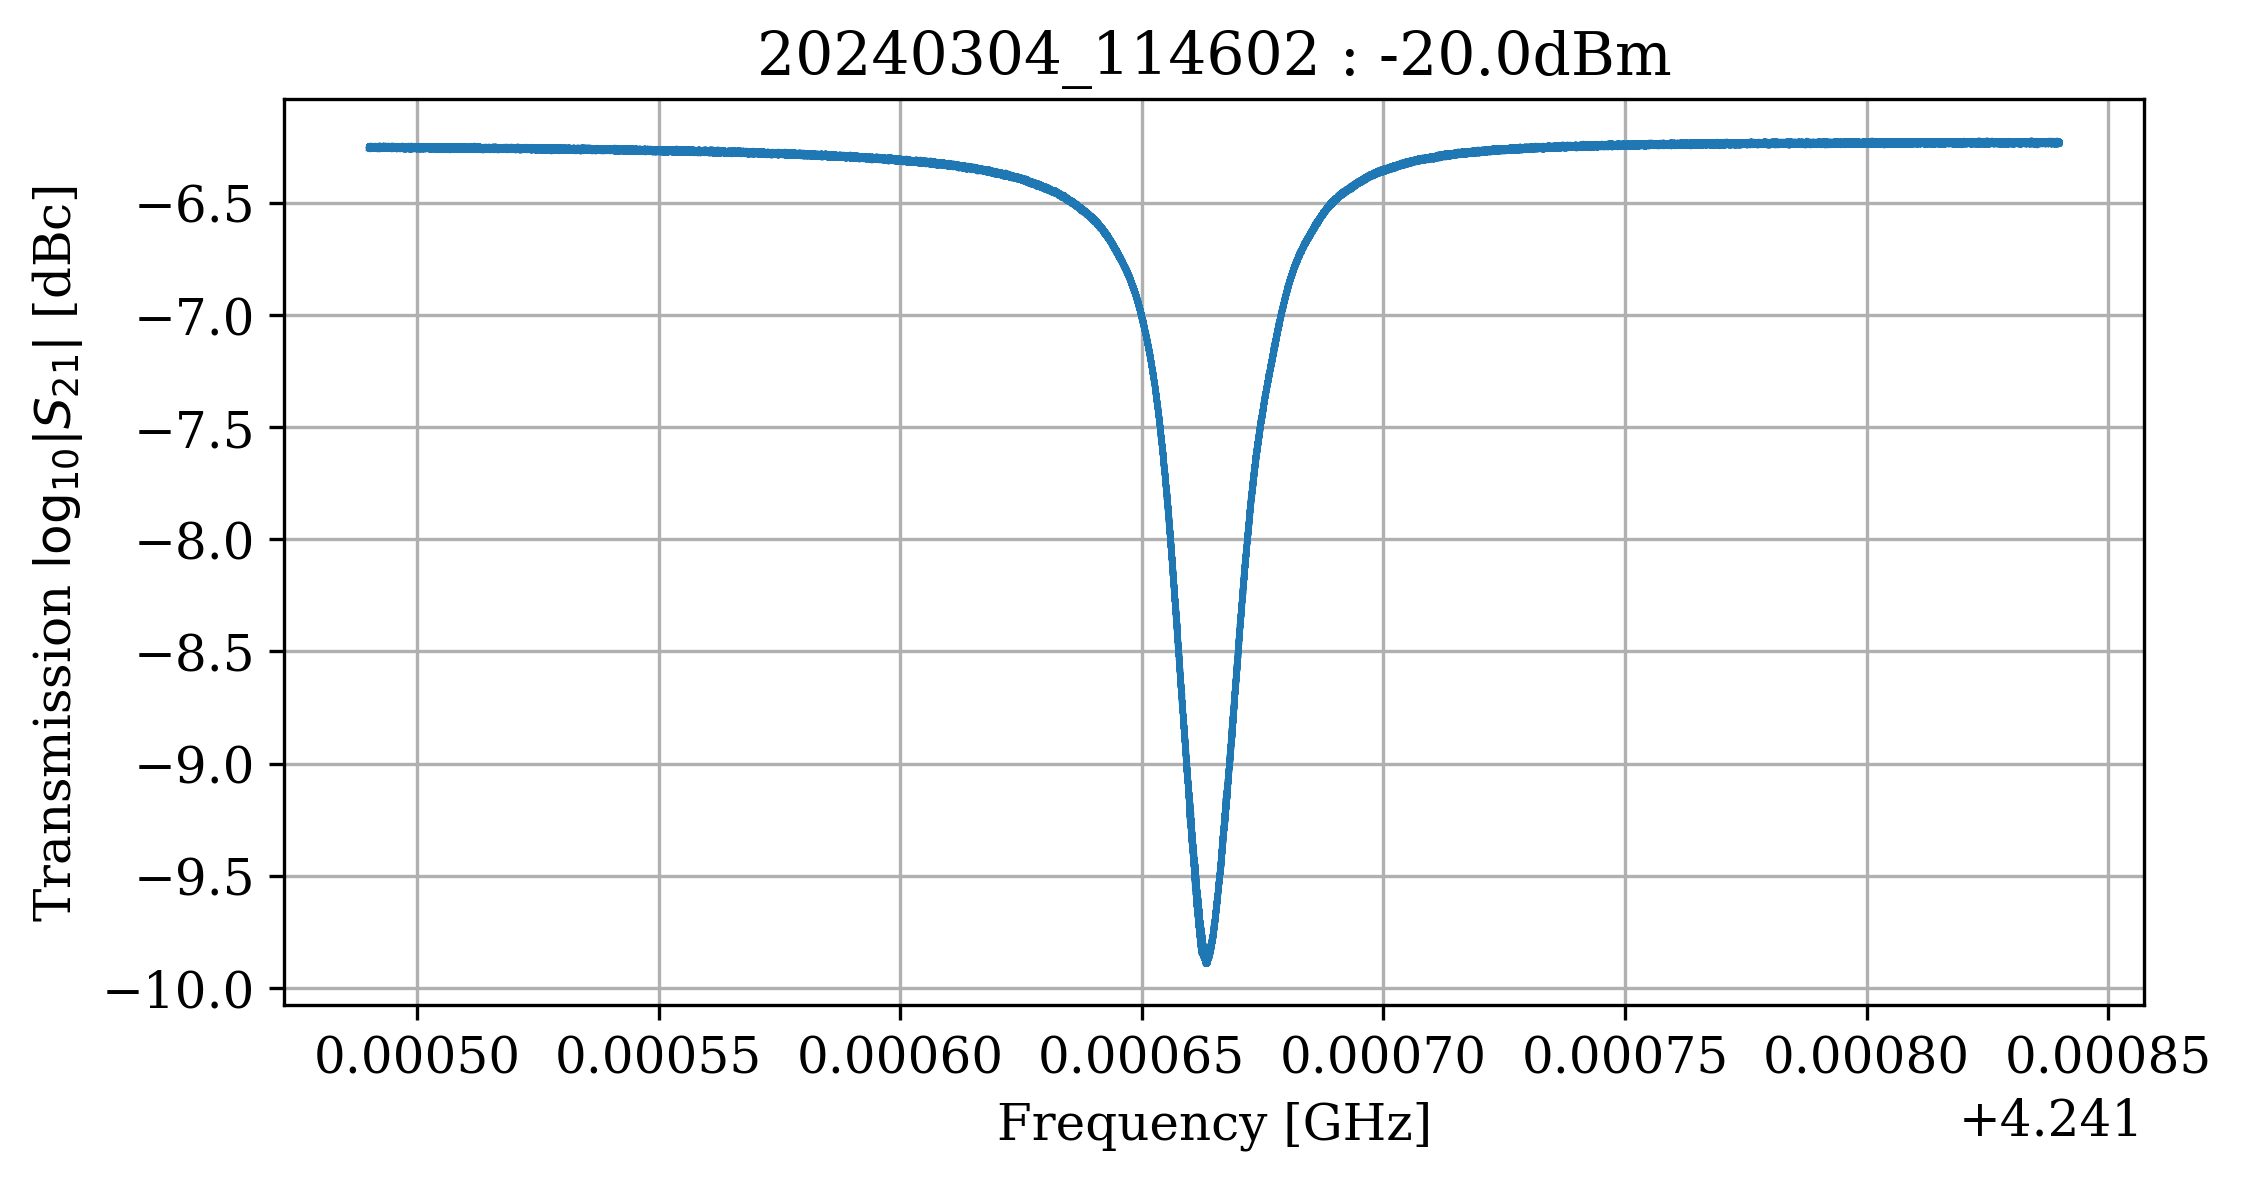

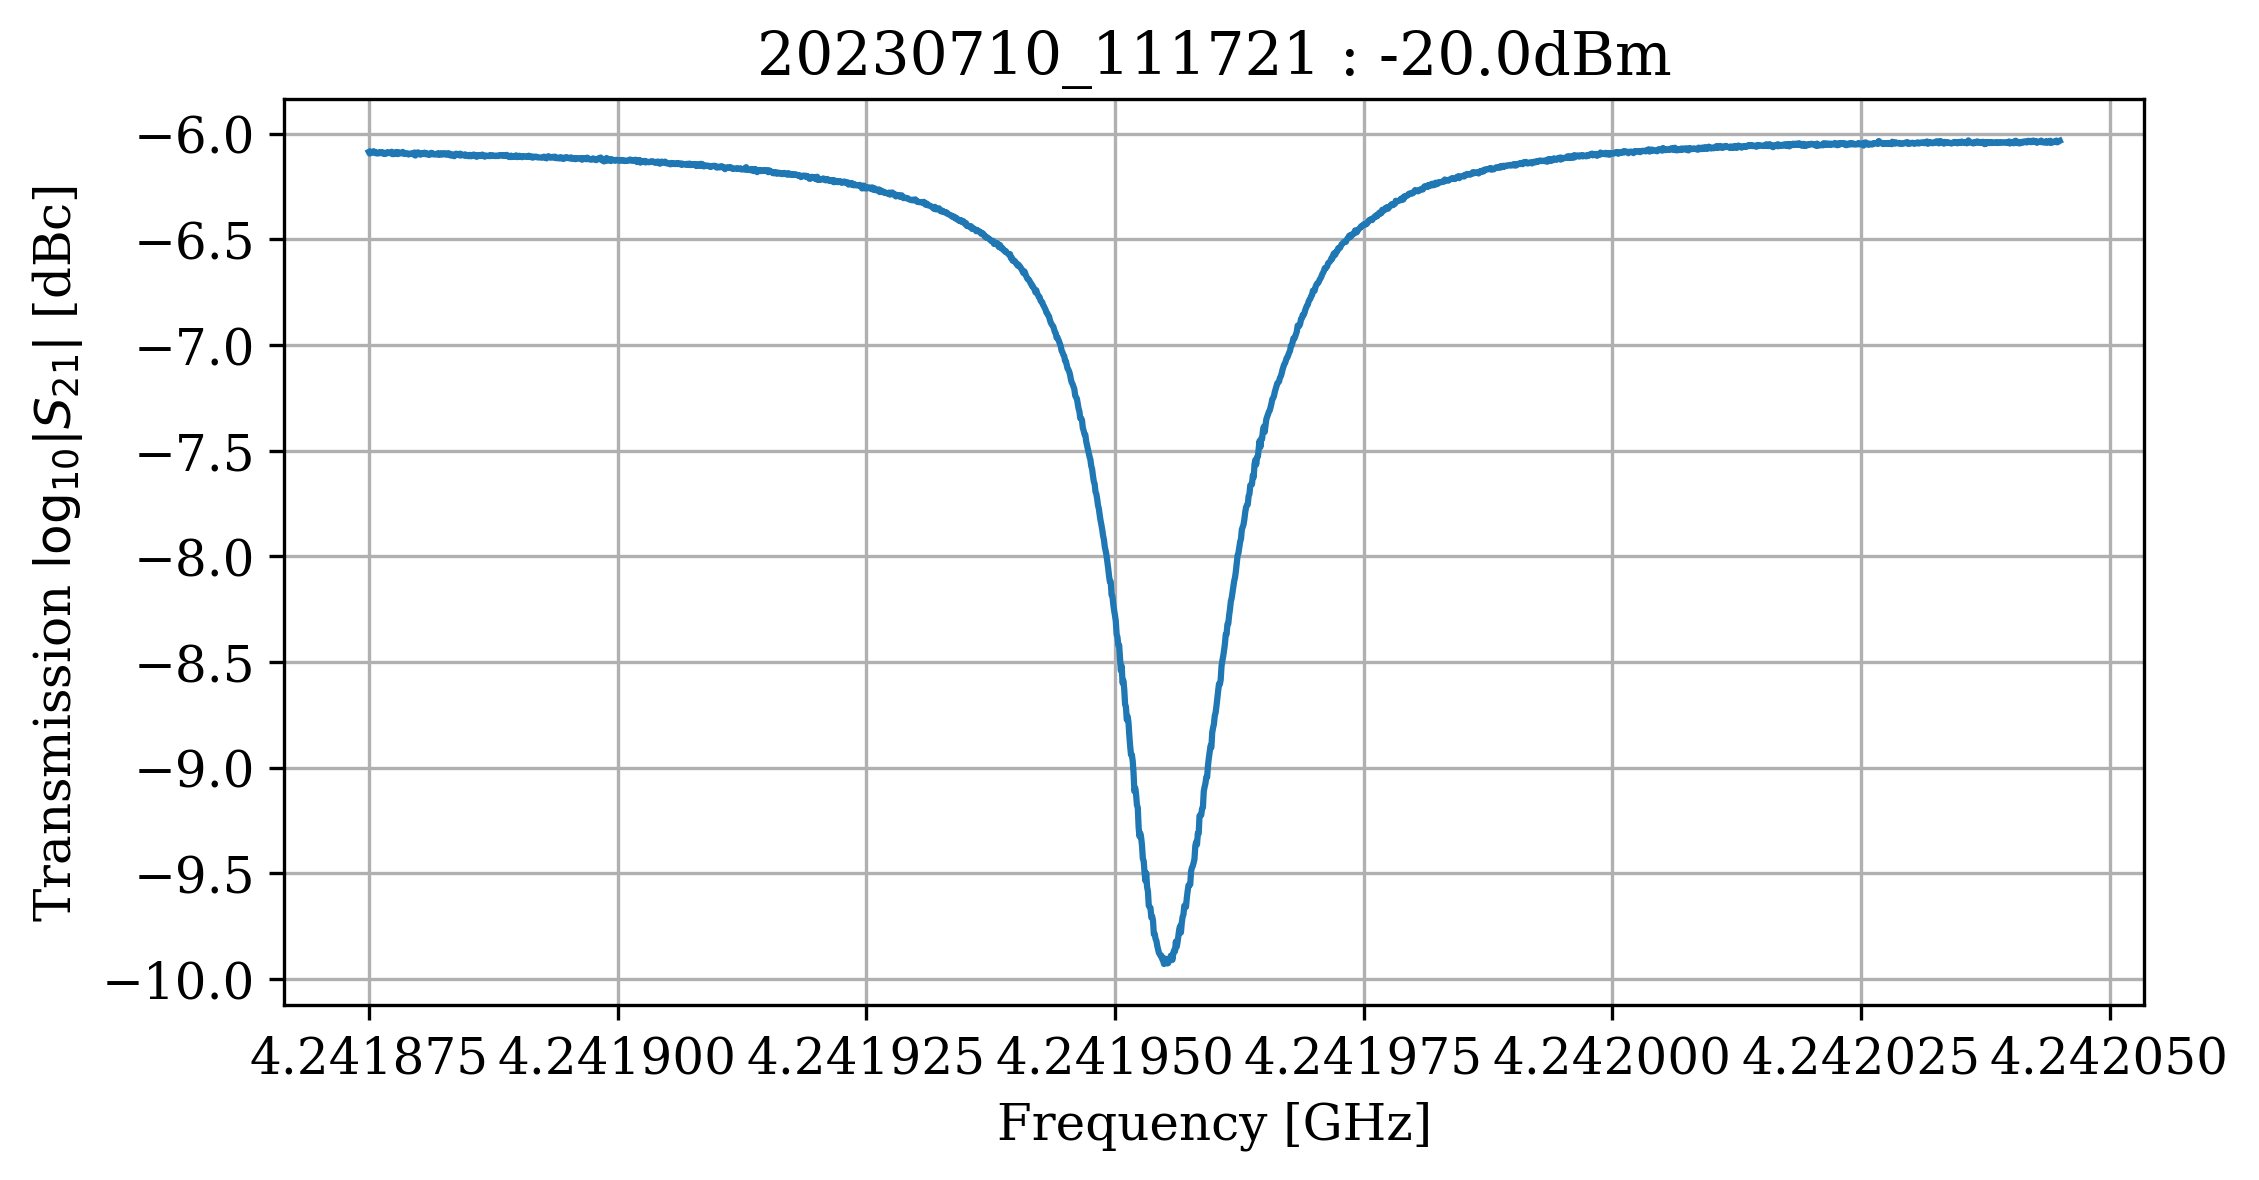

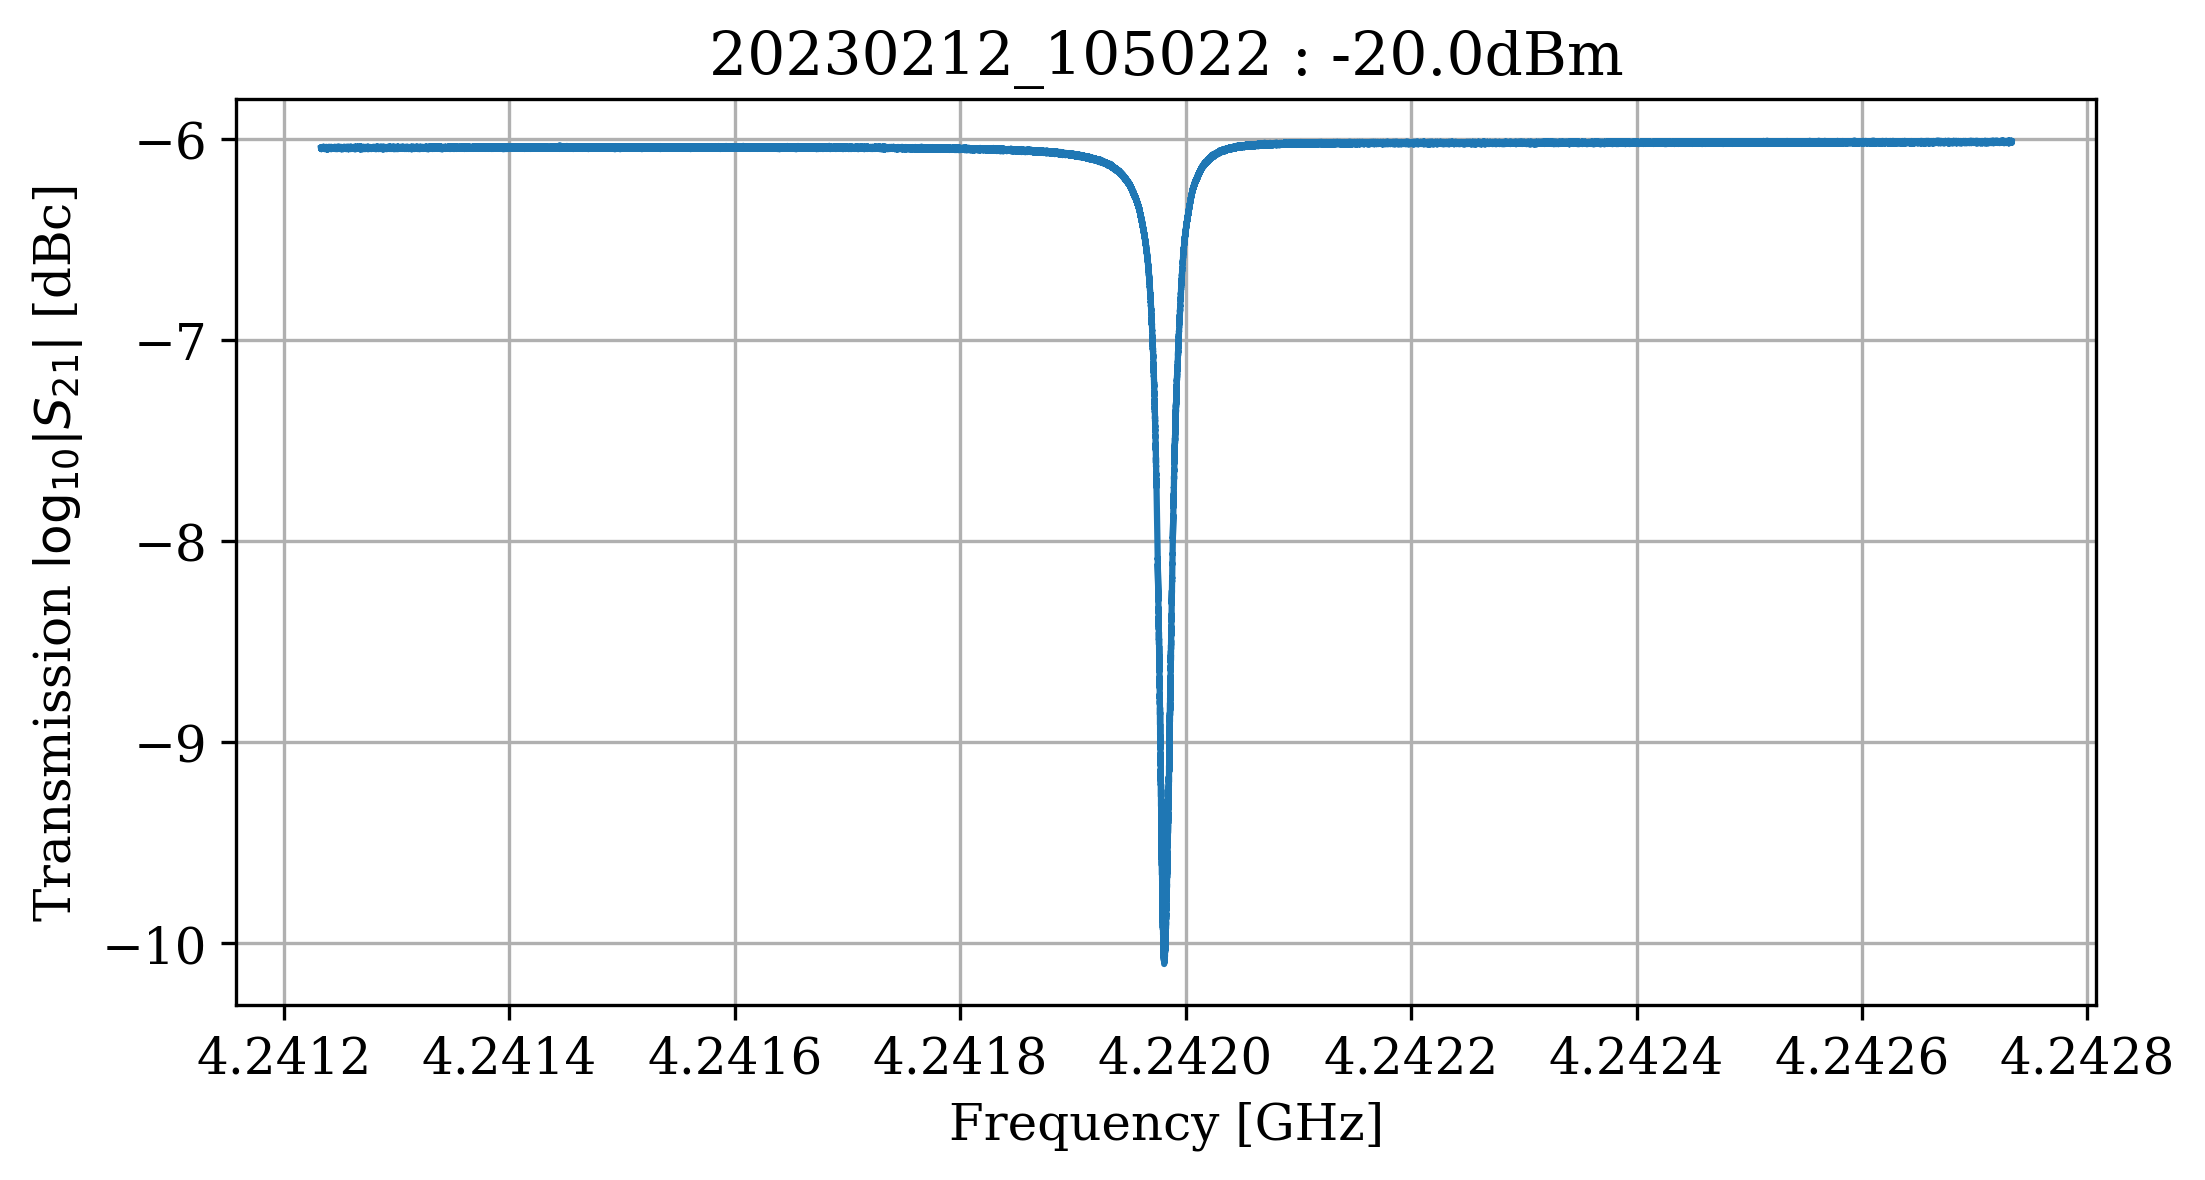

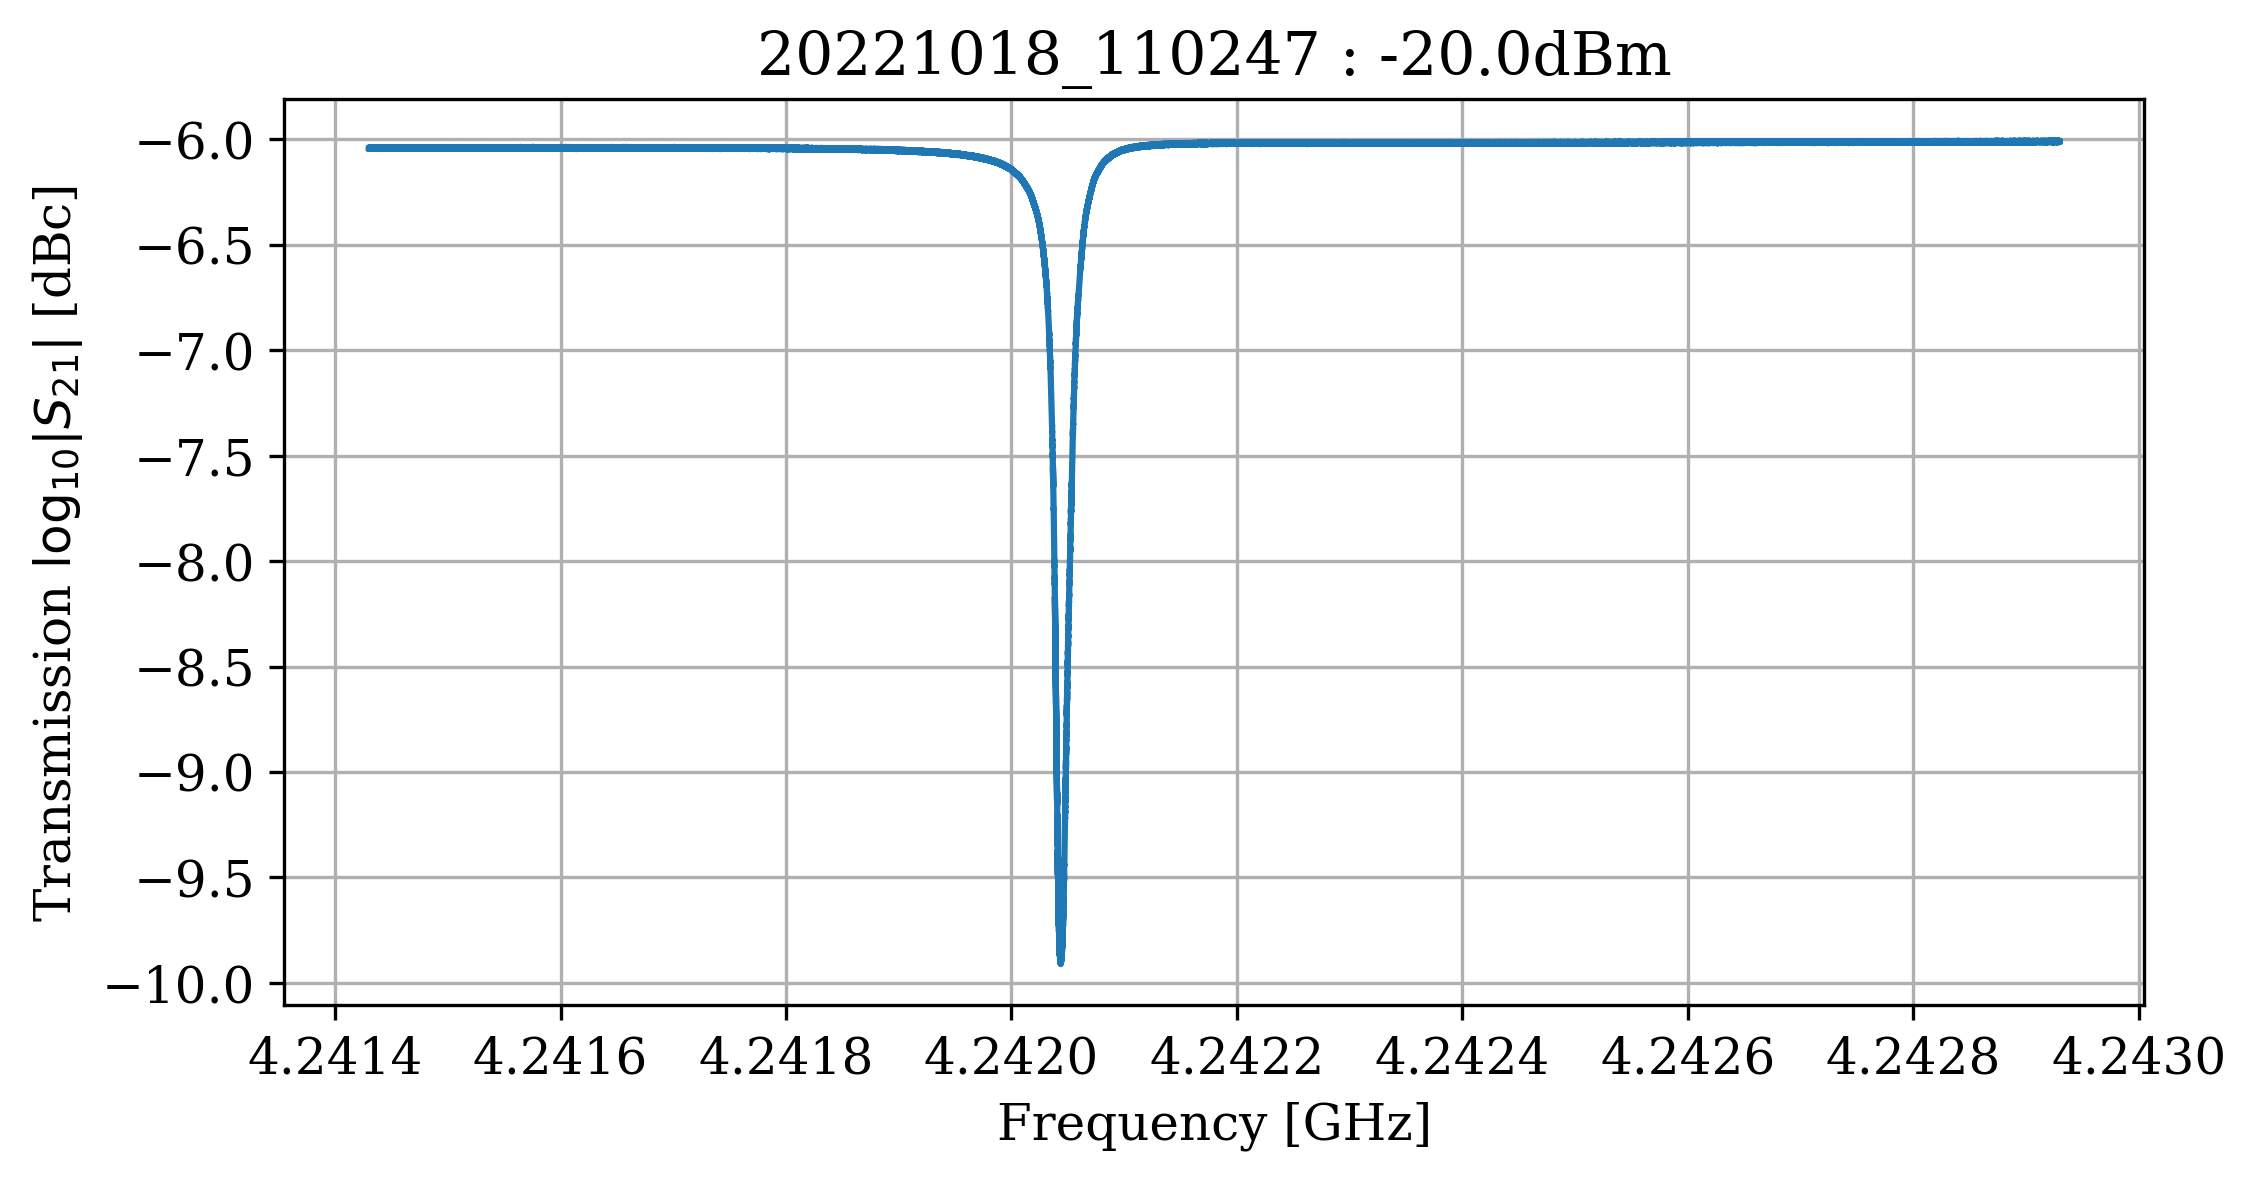

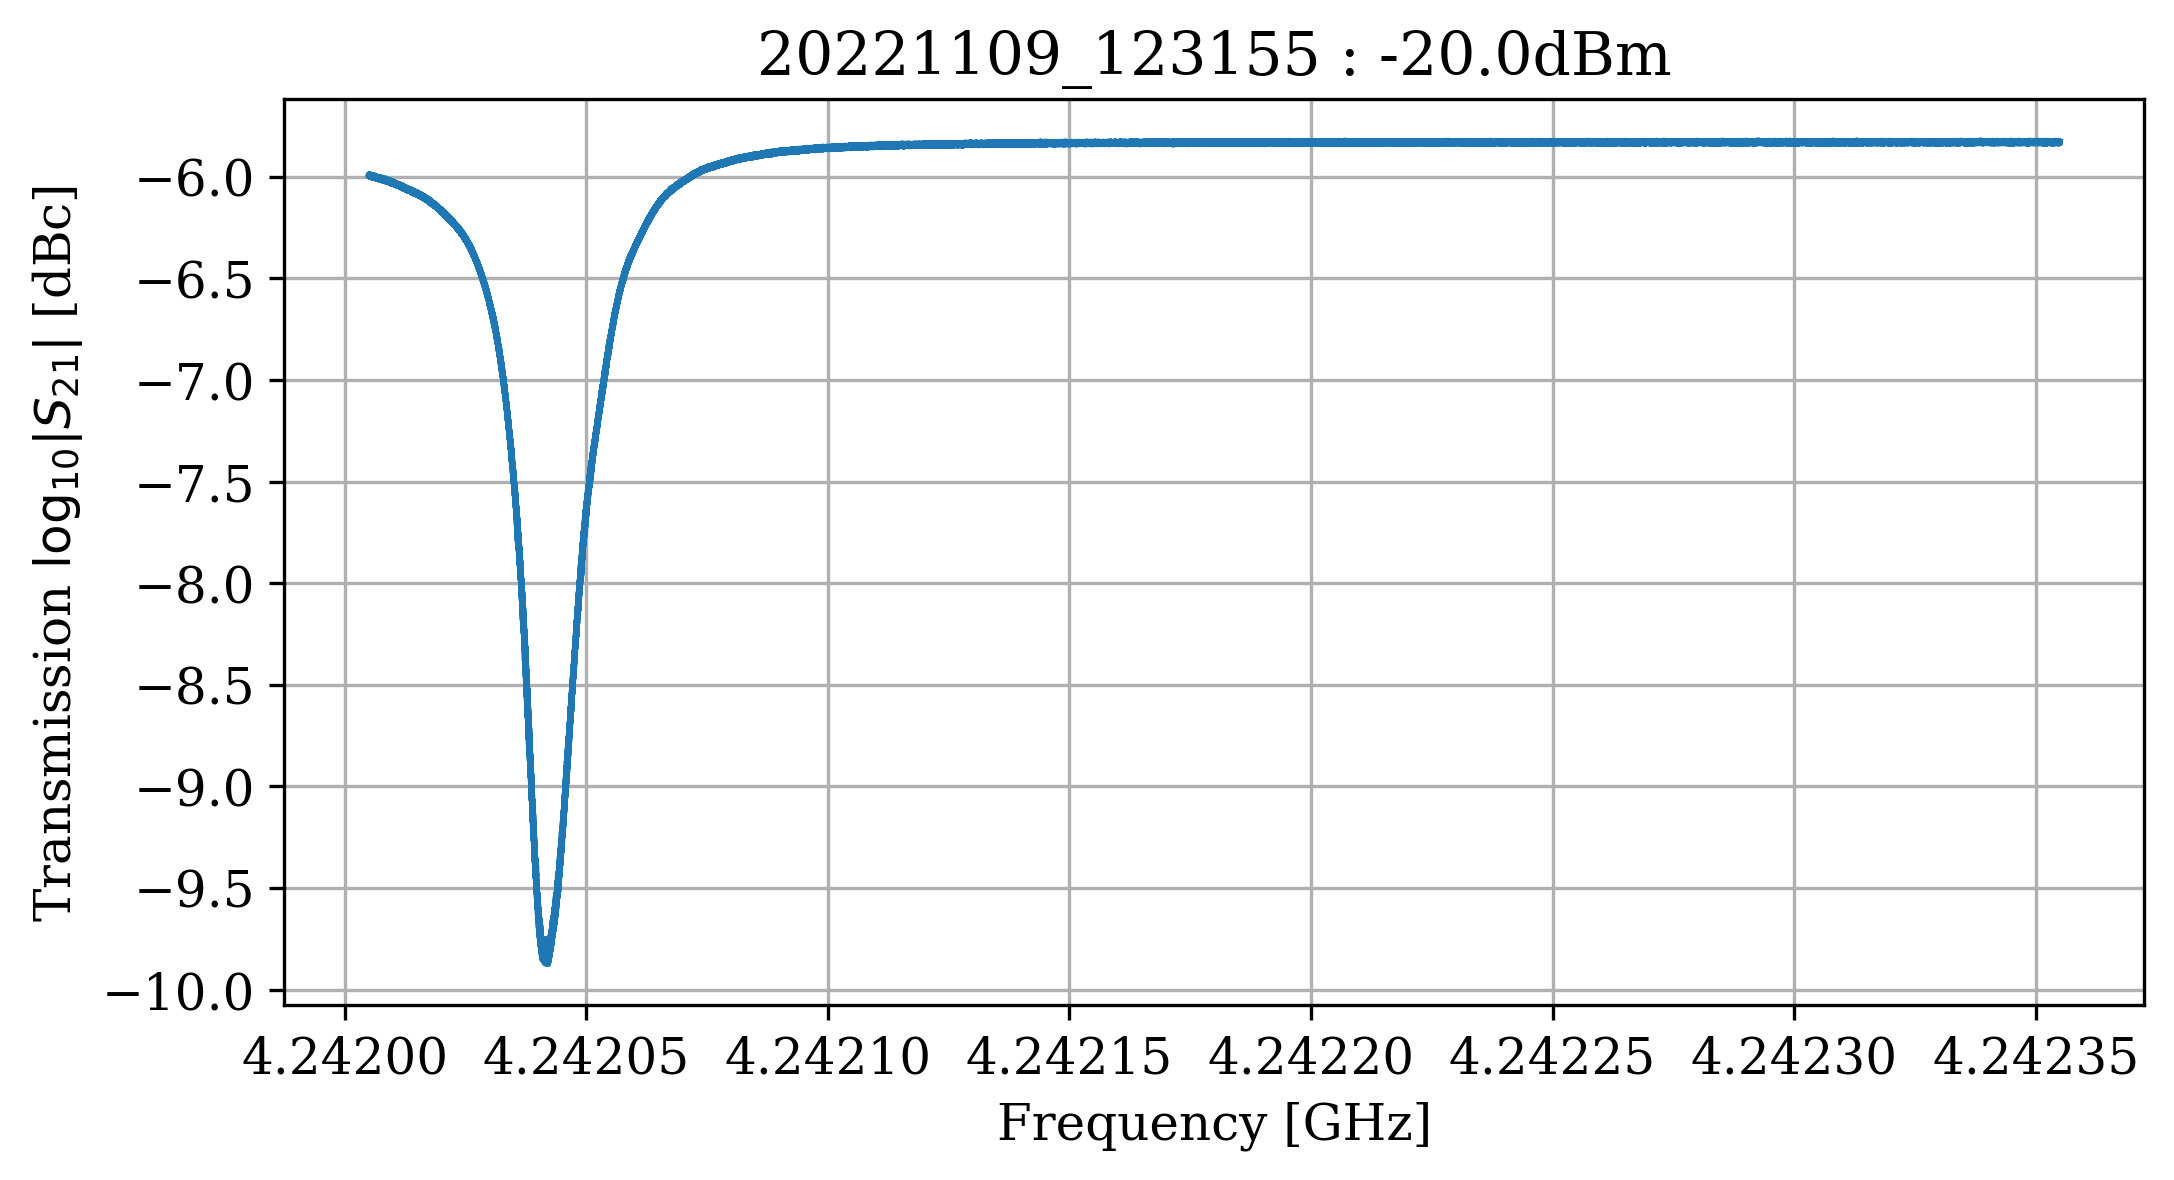

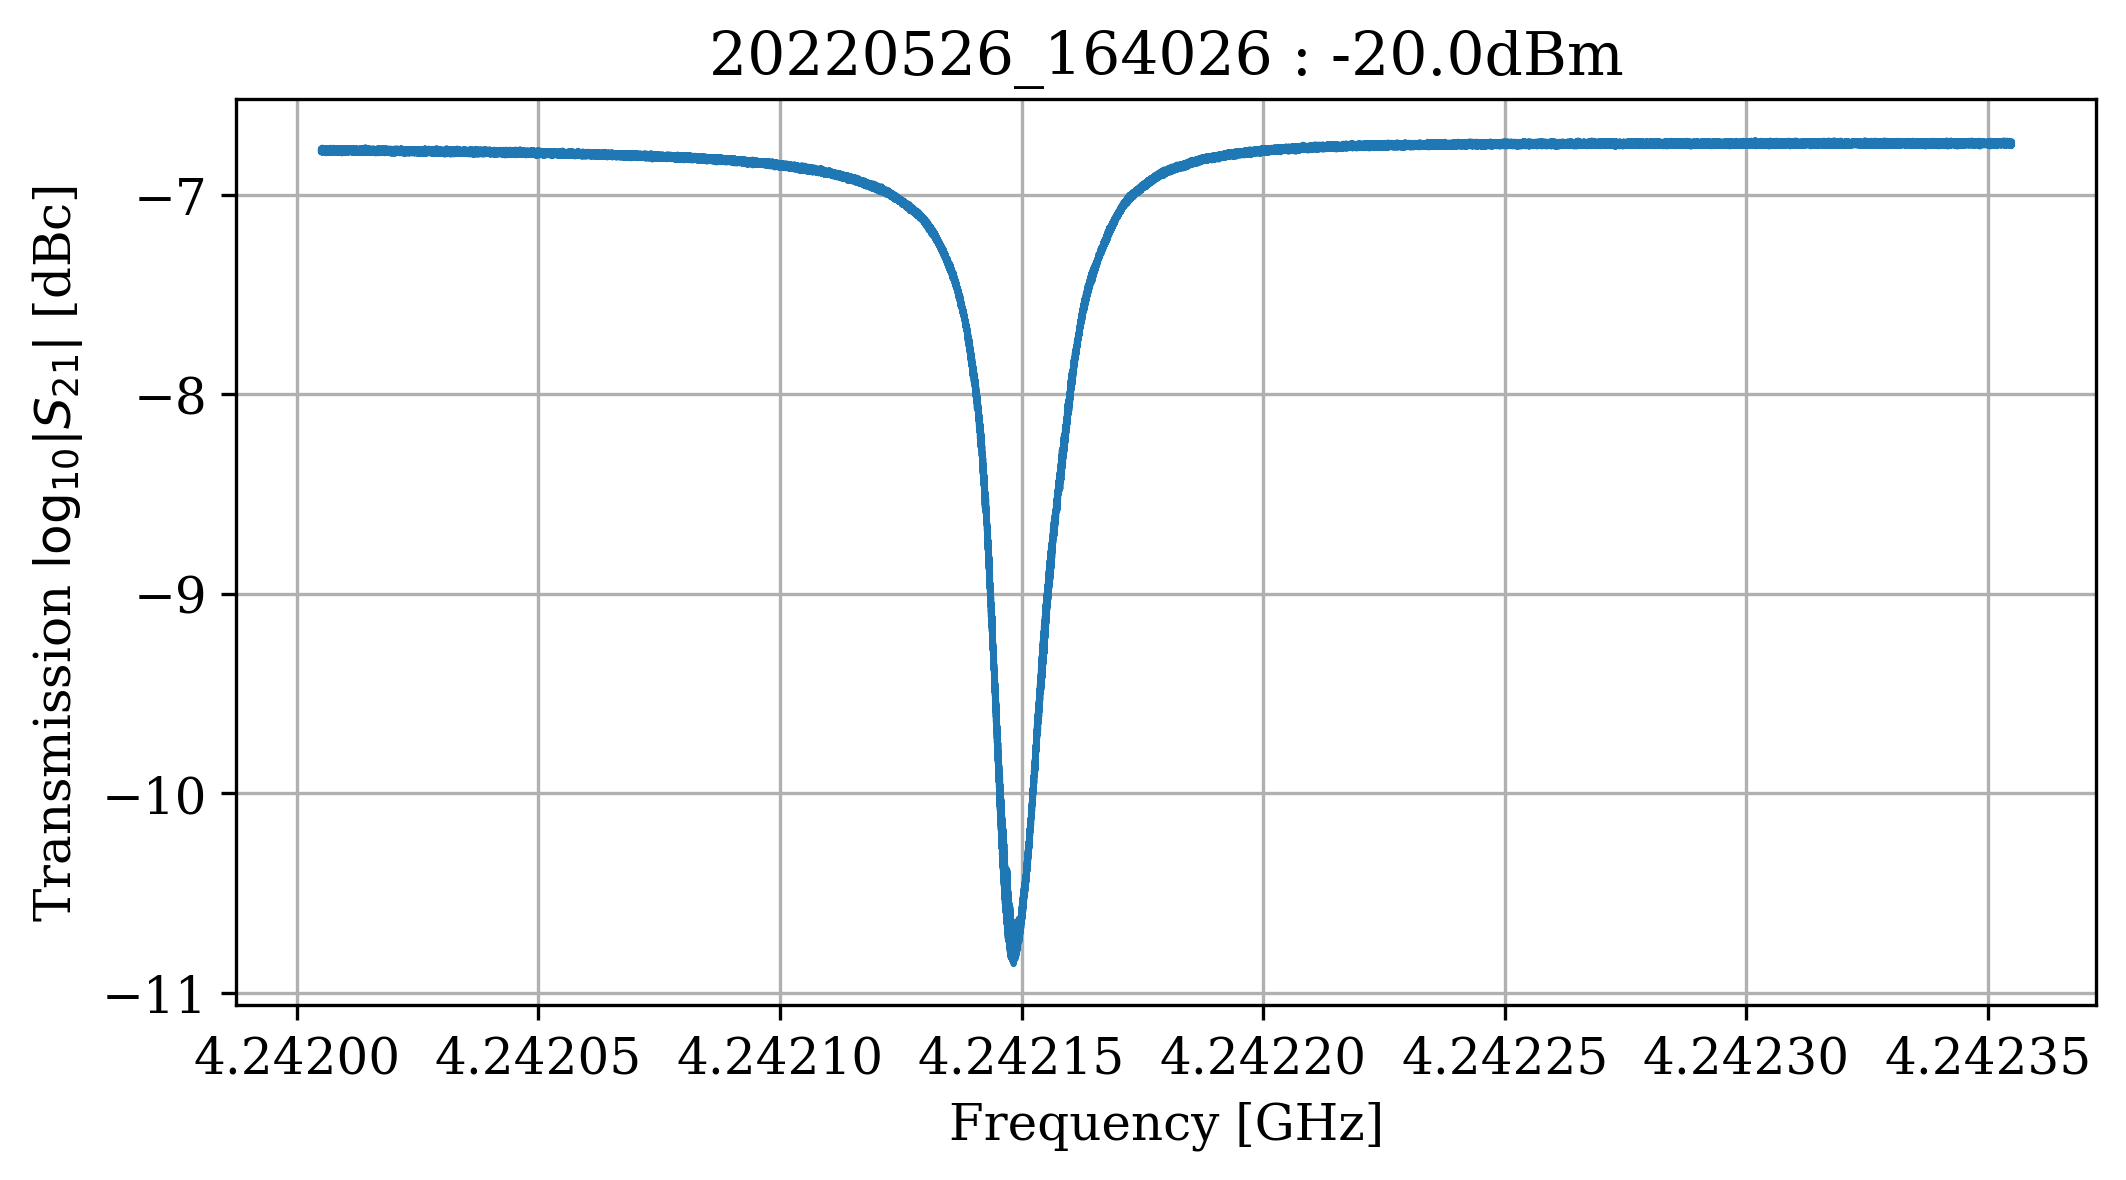

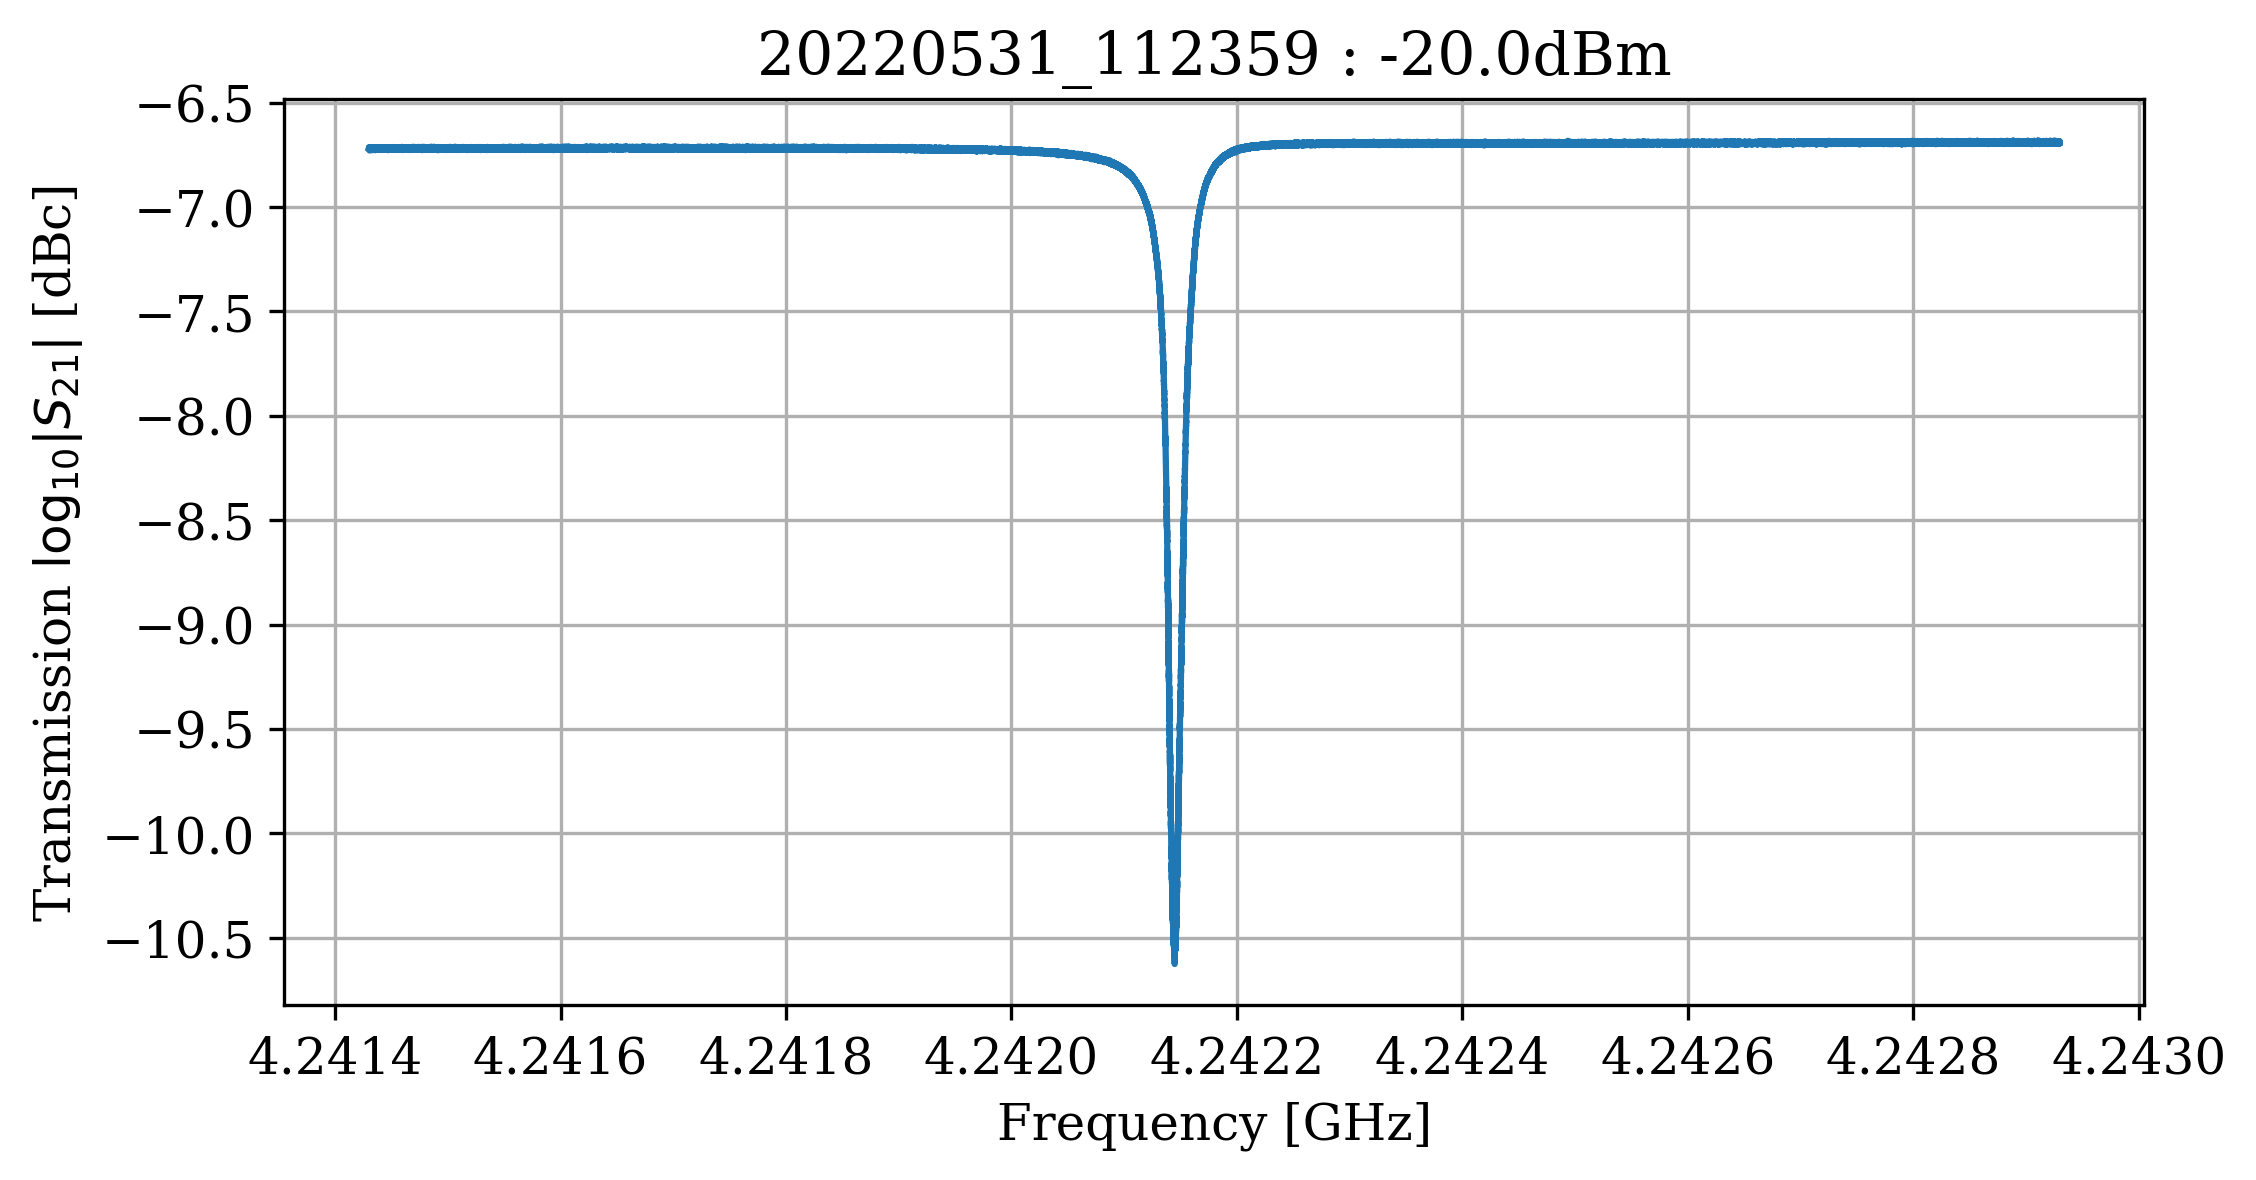

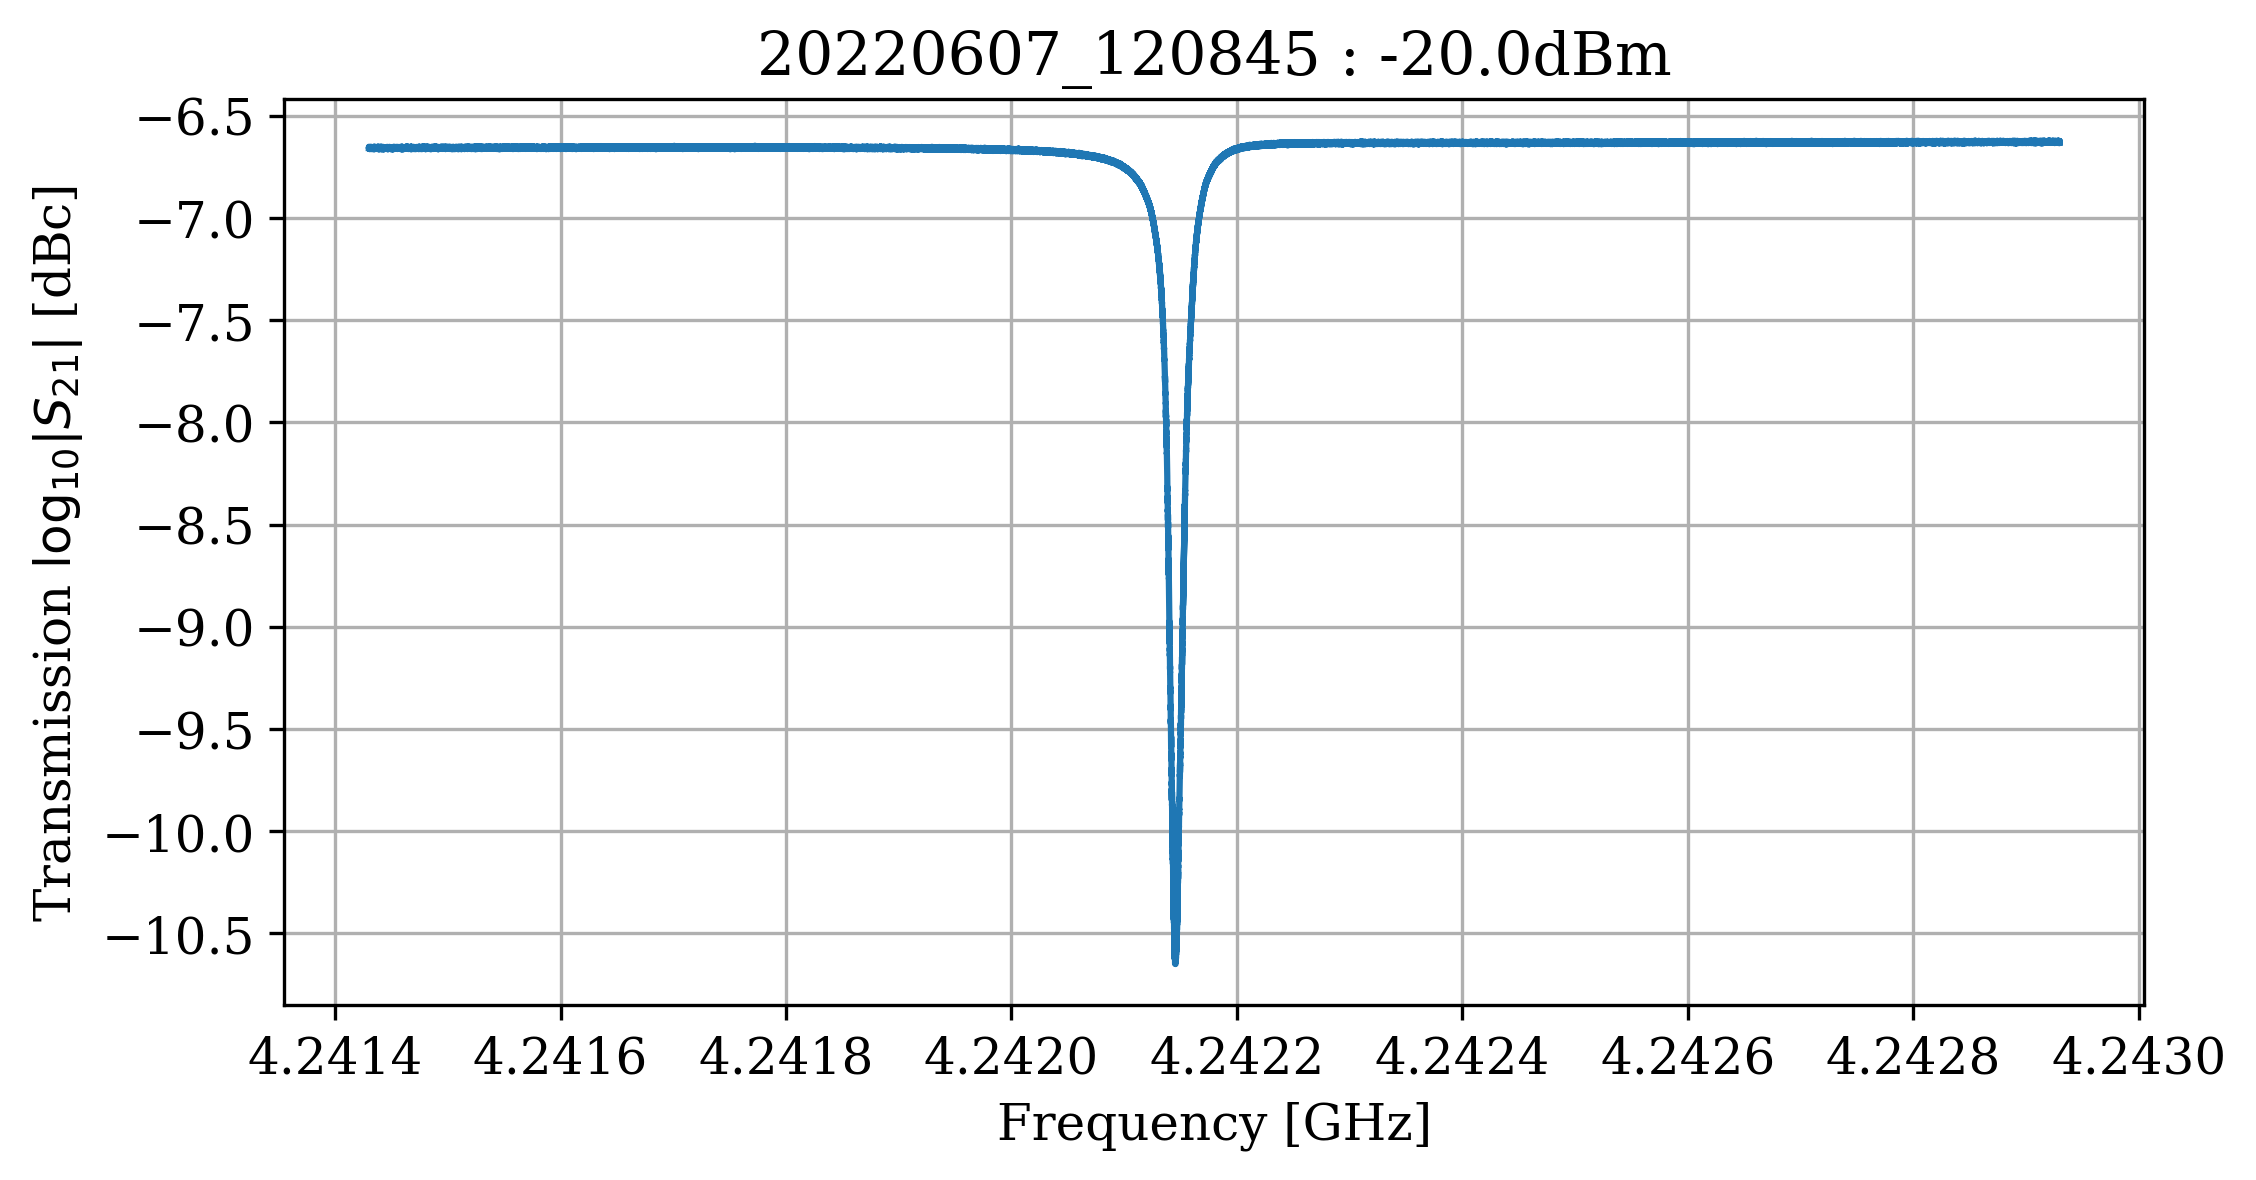

In [12]:
## Loop over the data in a single NEXUS run
for NR_key in run_keys:
    NR_data = data_runs[NR_key]
    
    ## Get the dates of data in this NEXUS run
    data_day_strs = [k for k in NR_data.keys()]
    
    ## Loop over every day with data in this NEXUS run
    for day_str in data_day_strs:
        day_data  = NR_data[day_str]
        
        ## Get the series of data from this NEXUS run
        series_strs   = [k for k in day_data.keys()]
        
        ## Loop over every data series in this NEXUS run
        for series_str in series_strs:
            print(NR_key, series_str)
            
            series_files = day_data[series_str]
            
            ## Create arrays for fit results by power
            P_vals  = np.zeros(len(series_files))
            fr_vals = np.zeros(len(series_files))
            Qr_vals = np.zeros(len(series_files))
            Qc_vals = np.zeros(len(series_files))
            Qi_vals = np.zeros(len(series_files))
            
            ## Loop over every file in this data series
            for i, vna_file in enumerate(series_files):
                P, fr, Qr, Qc, Qi, this_f_r = fit_single_file(vna_file)
                P_vals[i]  = P
                fr_vals[i] = fr
                Qr_vals[i] = Qr
                Qc_vals[i] = Qc
                Qi_vals[i] = Qi
                
            ## Create a dict of arrays we'll plot later
            result = {
                "power":  P_vals,
                "frVals": fr_vals,
                "QrVals": Qr_vals,
                "QcVals": Qc_vals,
                "QiVals": Qi_vals,
            }
            
            data_runs[NR_key][day_str][series_str+"_result"] = result
            

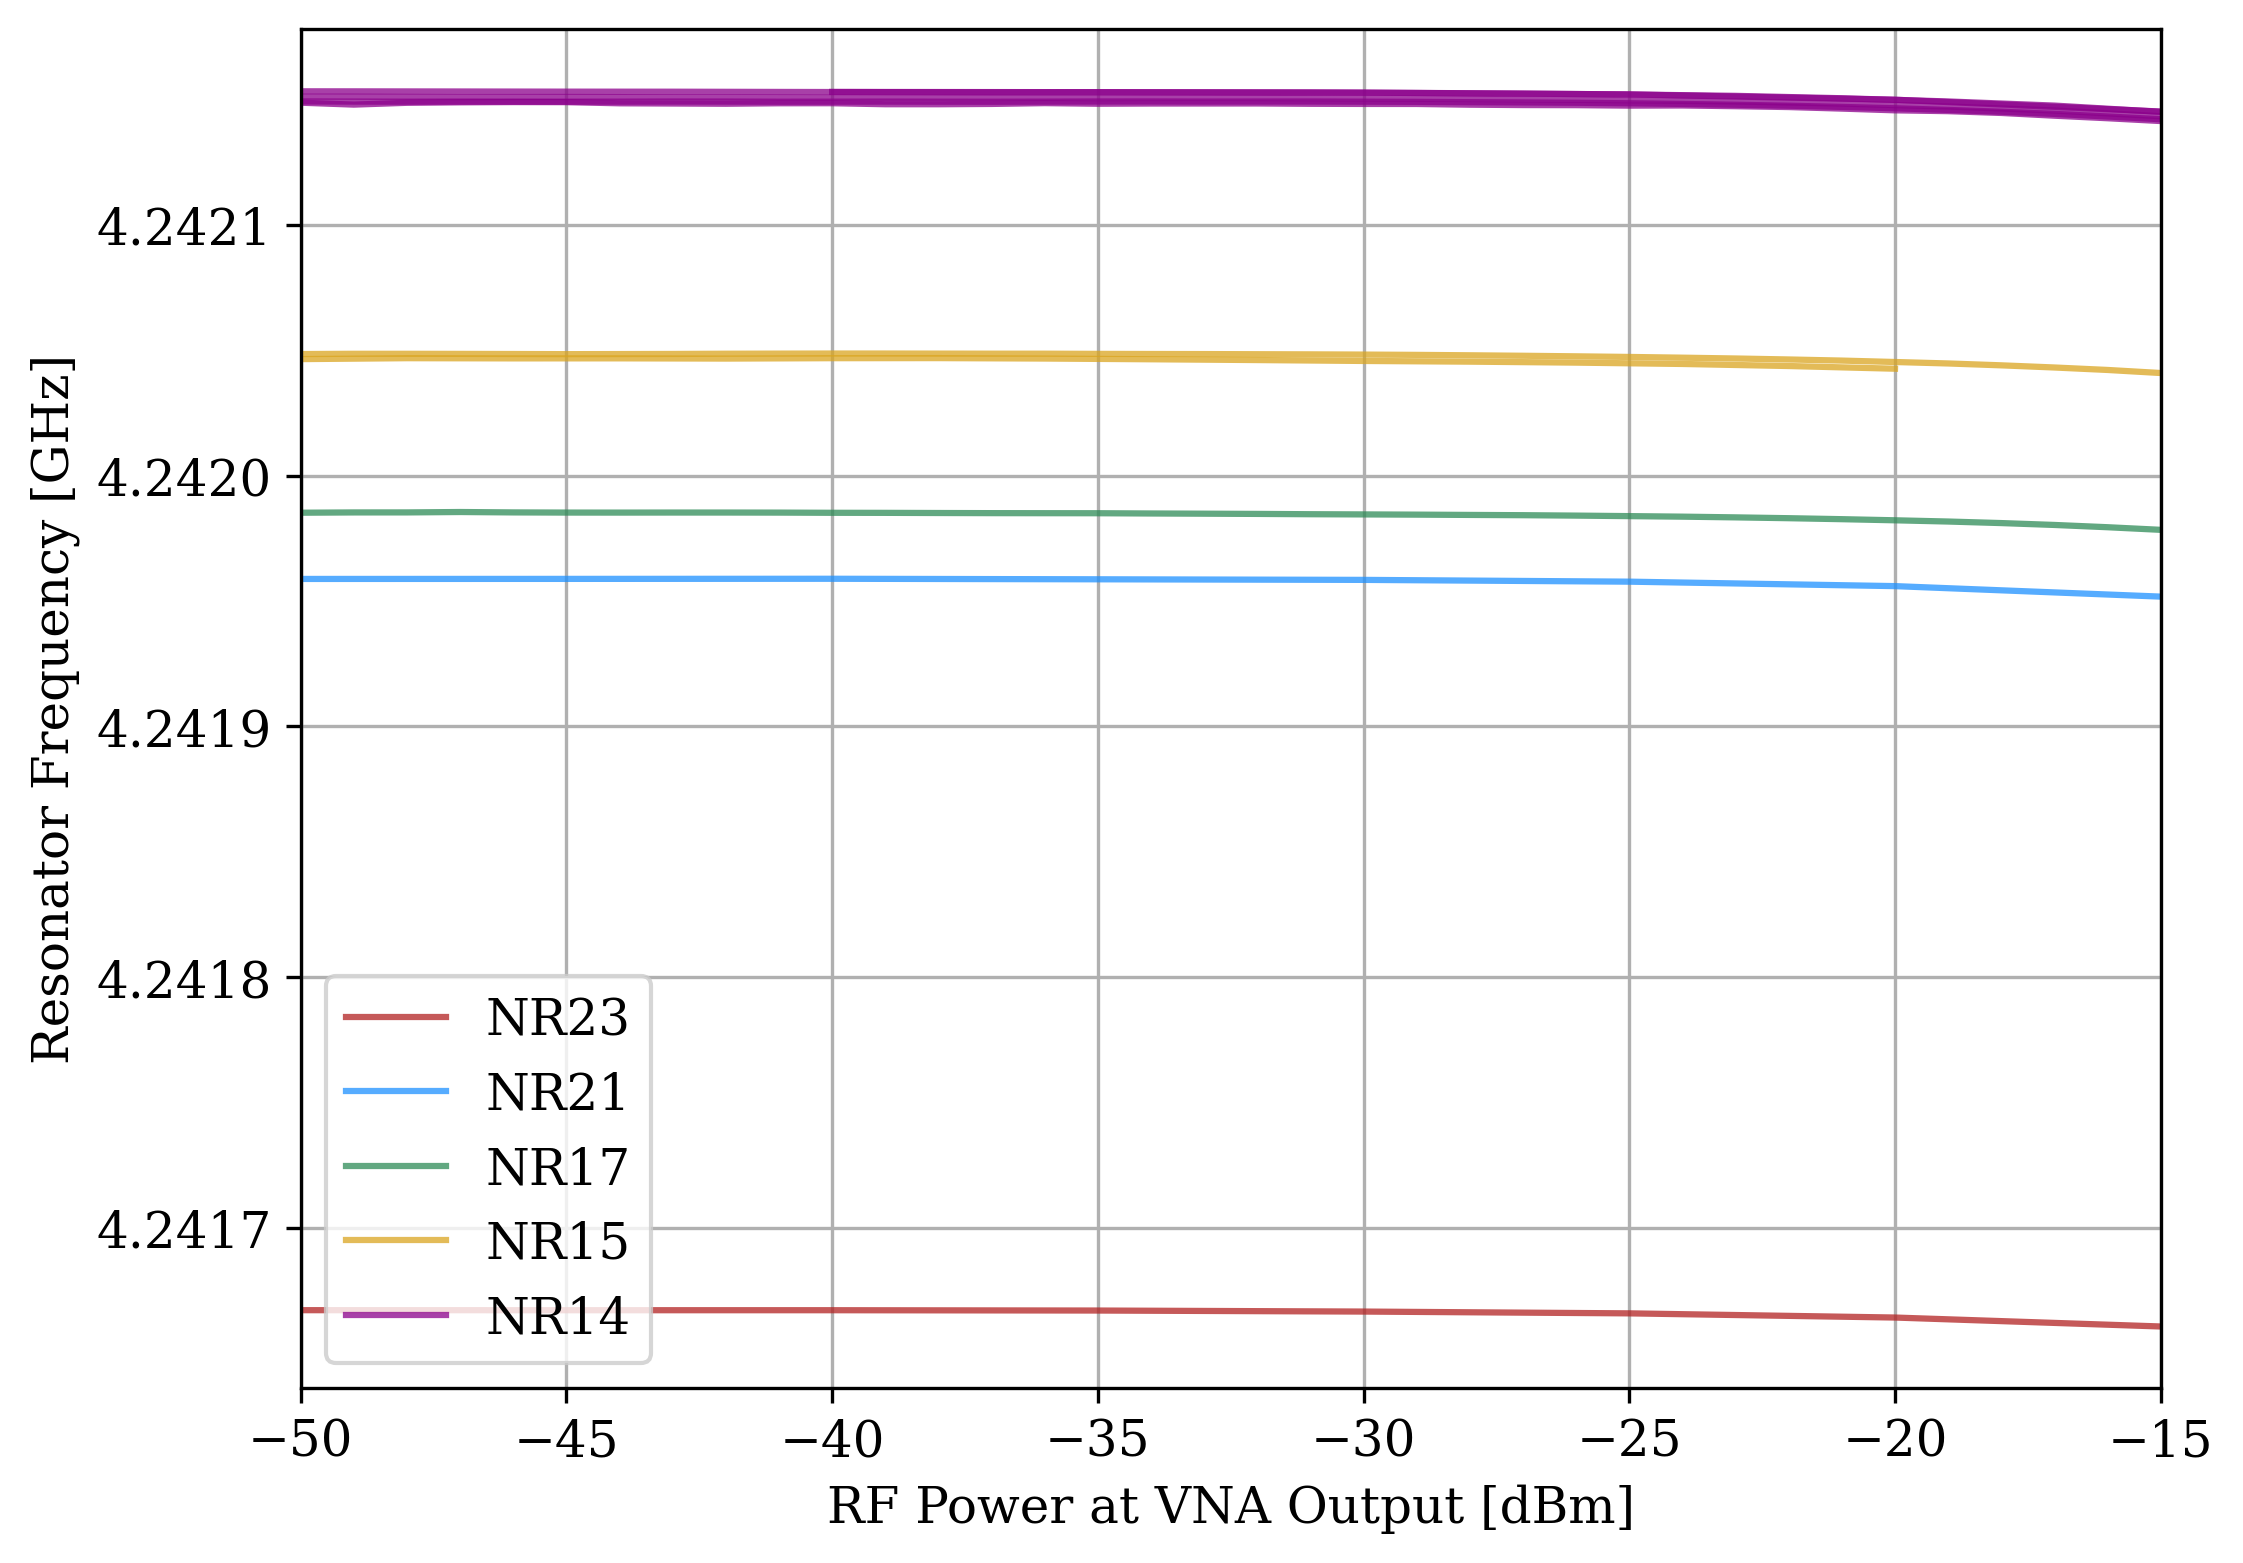

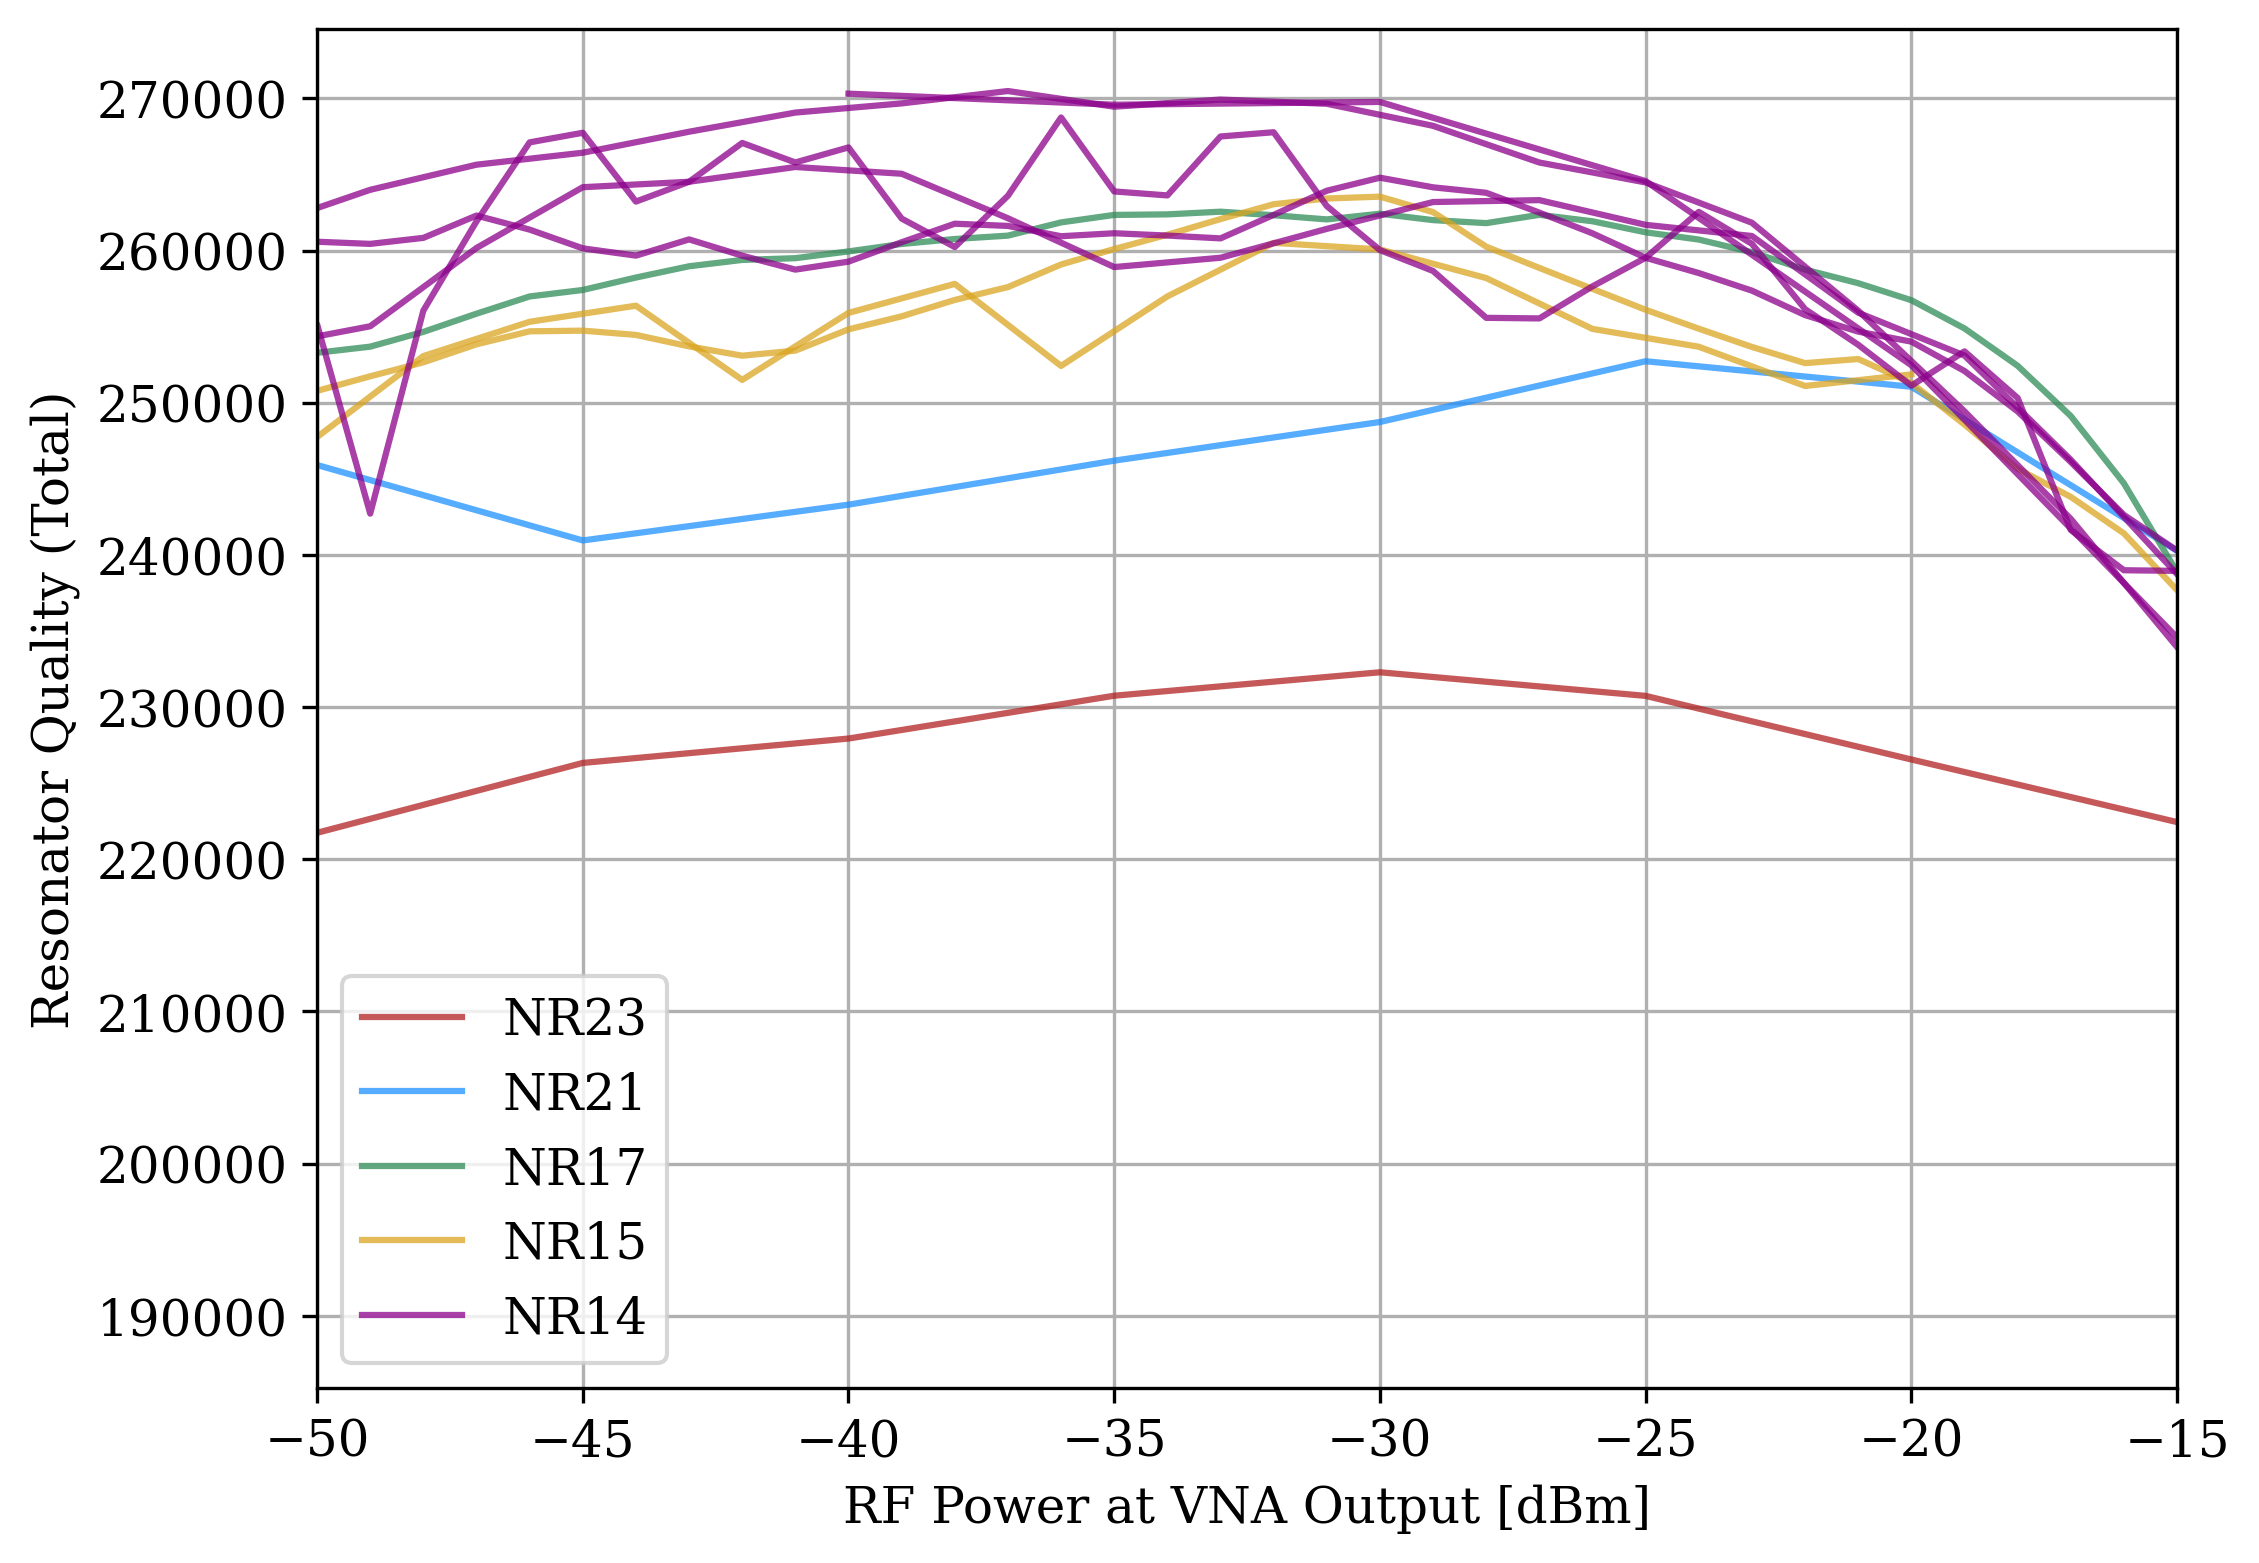

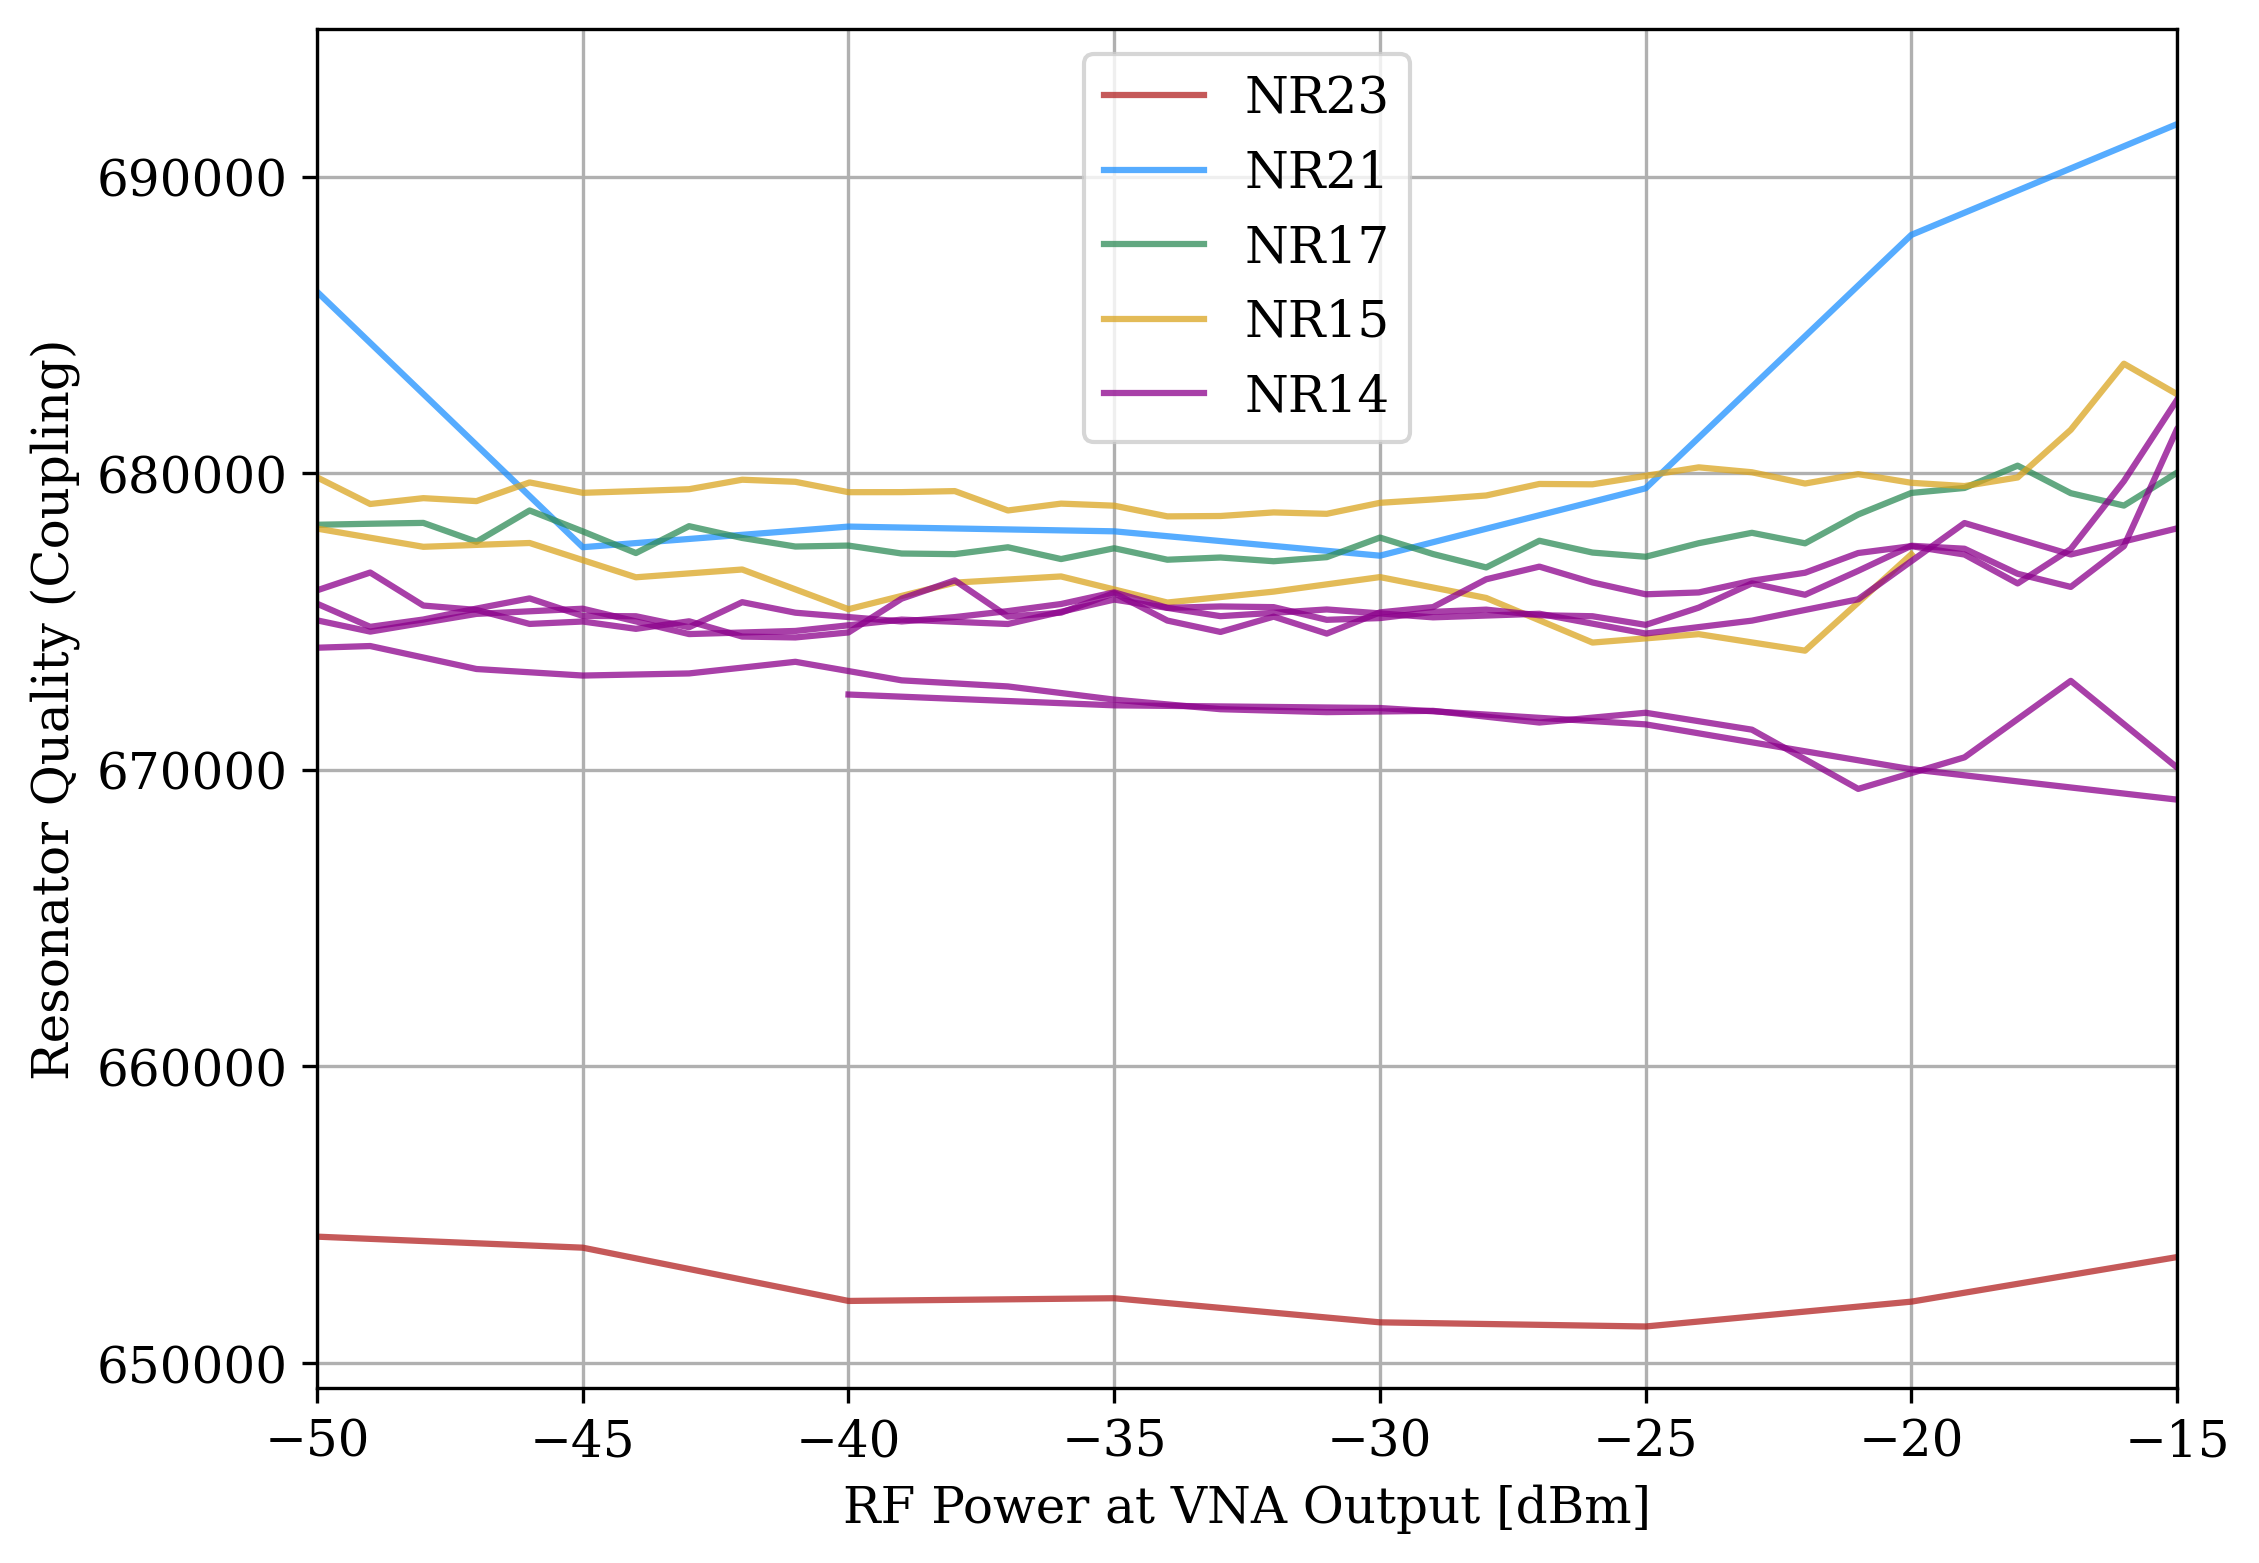

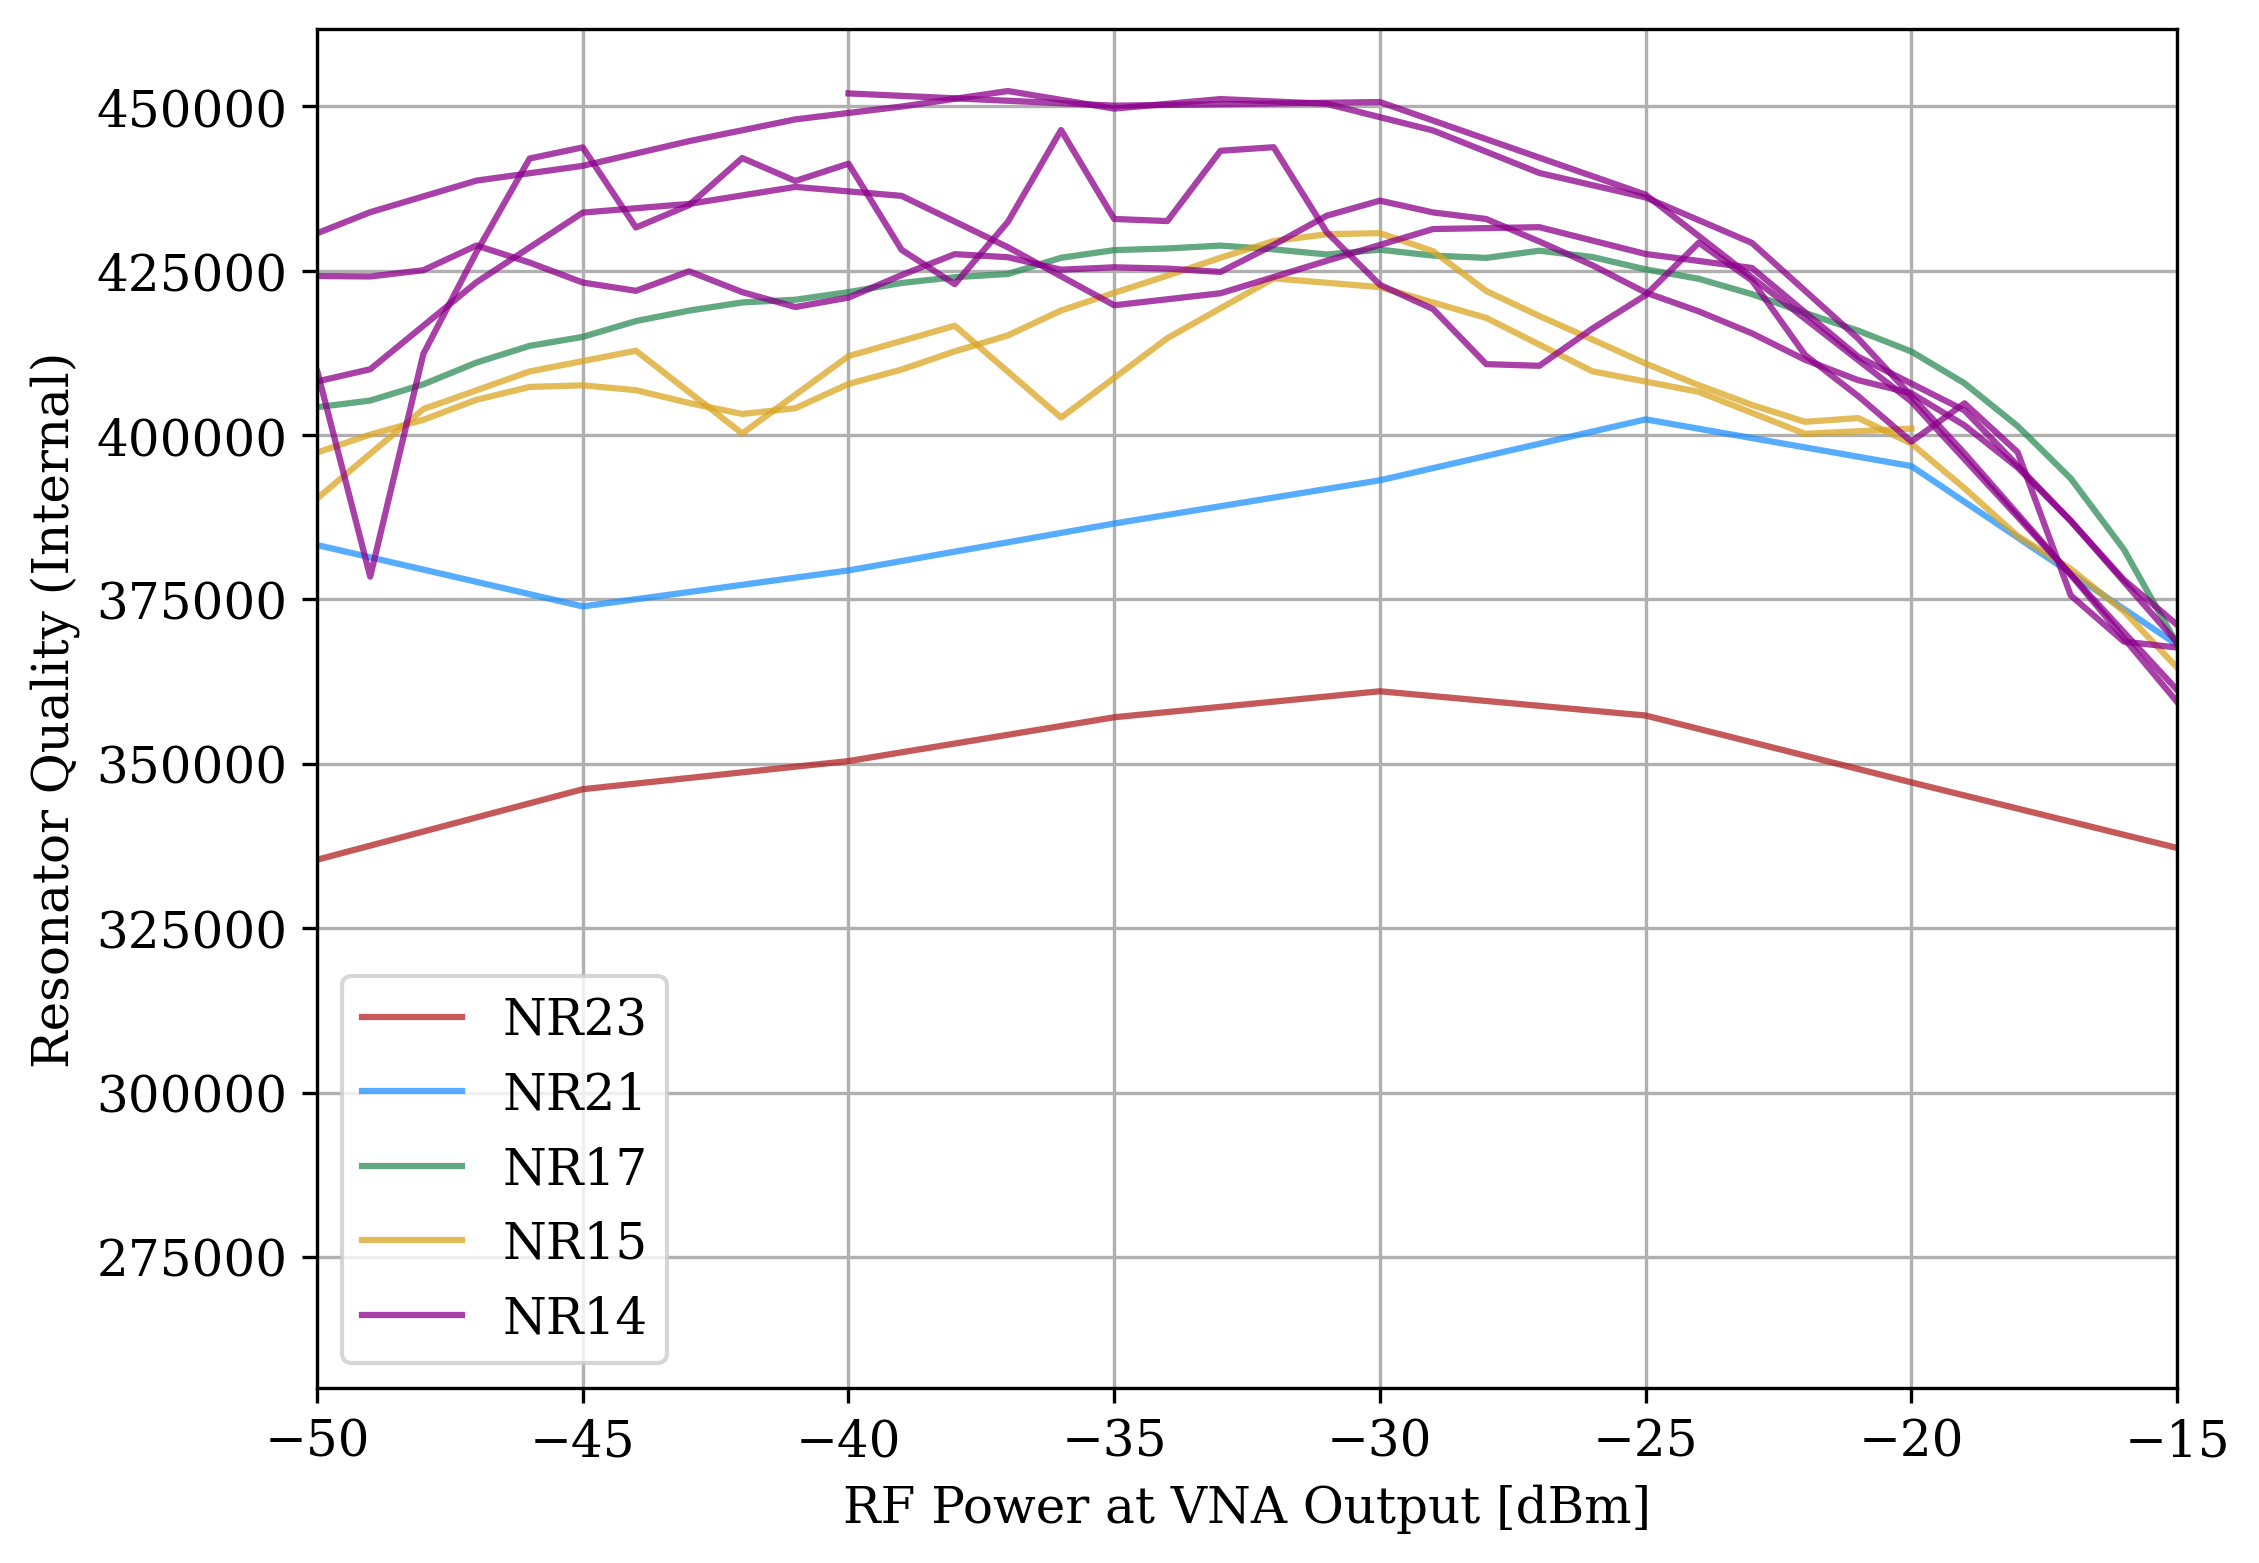

In [13]:
run_colors = ['firebrick', 'dodgerblue', 'seagreen', 'goldenrod', 'darkmagenta']
plot_xlims = [-50.0 , -15.0]
plot_alpha = 0.75

fig_fr = plt.figure("fr", figsize=(8,6), dpi=300)
ax_fr  = fig_fr.gca()
ax_fr.set_xlabel("RF Power at VNA Output [dBm]")
ax_fr.set_ylabel("Resonator Frequency [GHz]")
ax_fr.set_xlim(plot_xlims)

fig_Qr = plt.figure("Qr", figsize=(8,6), dpi=300)
ax_Qr  = fig_Qr.gca()
ax_Qr.set_xlabel("RF Power at VNA Output [dBm]")
ax_Qr.set_ylabel("Resonator Quality (Total)")
ax_Qr.set_xlim(plot_xlims)

fig_Qc = plt.figure("Qc", figsize=(8,6), dpi=300)
ax_Qc  = fig_Qc.gca()
ax_Qc.set_xlabel("RF Power at VNA Output [dBm]")
ax_Qc.set_ylabel("Resonator Quality (Coupling)")
ax_Qc.set_xlim(plot_xlims)

fig_Qi = plt.figure("Qi", figsize=(8,6), dpi=300)
ax_Qi  = fig_Qi.gca()
ax_Qi.set_xlabel("RF Power at VNA Output [dBm]")
ax_Qi.set_ylabel("Resonator Quality (Internal)")
ax_Qi.set_xlim(plot_xlims)

## Loop over the data in a single NEXUS run
for jj, NR_key in enumerate(run_keys):
    NR_data = data_runs[NR_key]
    first_plot = True
    
    ## Get the dates of data in this NEXUS run
    data_day_strs = [k for k in NR_data.keys()]
    
    ## Loop over every day with data in this NEXUS run
    for day_str in data_day_strs:
        day_data  = NR_data[day_str]
        
        ## Get the series of data from this NEXUS run
        series_strs   = [k for k in day_data.keys()]
        
        ## Loop over every data series in this NEXUS run
        for series_str in series_strs:
            
            ## Look only at the entries that contain the results
            if "result" in series_str: 
                # print(NR_key, series_str)
                
                result = day_data[series_str]
                
                run_label = "NR"+str(NR_key) if first_plot else None
                
                ax_fr.plot( result['power'] , result['frVals'], ls='-', color=run_colors[jj], alpha=plot_alpha, label=run_label )
                ax_Qr.plot( result['power'] , result['QrVals'], ls='-', color=run_colors[jj], alpha=plot_alpha, label=run_label )
                ax_Qc.plot( result['power'] , result['QcVals'], ls='-', color=run_colors[jj], alpha=plot_alpha, label=run_label )
                ax_Qi.plot( result['power'] , result['QiVals'], ls='-', color=run_colors[jj], alpha=plot_alpha, label=run_label )
                
                first_plot = False
                
ax_fr.legend()
ax_Qr.legend()
ax_Qc.legend()
ax_Qi.legend()